# Analysis of vasopressor courses in MIMICIV
- Ruoyi Jiang

- To pull data... https://physionet.org/content/mimiciv/0.4/
- cd to base_dir to pull and set up


In [1]:
library(tidyverse)
library(fasttime)
library(epitools)
library(lme4)
library(pROC)
library(randomForest)
library(car)
library(JM)

── Attaching packages ──────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ─────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var


randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    mar

In [2]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-apple-darwin18.7.0 (64-bit)
Running under: macOS Mojave 10.14.6

Matrix products: default
BLAS:   /usr/local/Cellar/openblas/0.3.13/lib/libopenblasp-r0.3.13.dylib
LAPACK: /usr/local/Cellar/r/4.0.3_2/lib/R/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] splines   stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] JM_1.4-8            survival_3.2-7      nlme_3.1-149       
 [4] MASS_7.3-53         car_3.0-10          carData_3.0-4      
 [7] randomForest_4.6-14 pROC_1.16.2         lme4_1.1-26        
[10] Matrix_1.2-18       epitools_0.5-10.1   fasttime_1.0-2     
[13] forcats_0.5.0       stringr_1.4.0       dplyr_1.0.2        
[16] purrr_0.3.4         readr_1.4.0         tidyr_1.1.2        
[19] tibble_3.0.4        ggplot2_3.3.2       tidyverse_1.3.0    

loaded via a namespace (and not attached):
 [1] httr_1.4.2

# Definitions

In [3]:
# base theme for plots
base_theme <- function(){ theme_bw() + 
            theme(text=element_text(size=8)) +
            theme(plot.title=element_text(size=8)) +
            theme(plot.background=element_blank(),
                  panel.grid.major=element_blank(), 
                  panel.grid.minor=element_blank()) +
            theme(strip.background=element_blank(),
                  strip.text=element_text(size=7, face='bold')) +
            theme(axis.title=element_text(size=8, vjust=0.25),
                  axis.text.x=element_text(size=8, vjust=0.5, hjust=0.5),
                  axis.text.y=element_text(size=8)) +
            theme(legend.text=element_text(size=7),
                  legend.title=element_text(size=7),
                  legend.key.height=grid::unit(10, "points"), 
                  legend.key.width=grid::unit(10, "points"))}

In [5]:
# roc curve plotting
roc_with_ci <- function(obj) {
  ciobj <- ci.se(obj, specificities = seq(0, 1, l = 25))
  dat.ci <- data.frame(x = as.numeric(rownames(ciobj)),
                       lower = ciobj[, 1],
                       upper = ciobj[, 3])
  
  ggroc(obj) +
    base_theme() +
    theme(axis.title=element_text(size=10)) +
    geom_abline(
      slope = 1,
      intercept = 1,
      linetype = "dashed",
      alpha = 0.7,
      color = '#2F4F4F'
    ) + coord_equal() +
    geom_ribbon(
      data = dat.ci,
      aes(x = x, ymin = lower, ymax = upper),
      fill = '#2F4F4F',
      alpha = 0.2
    ) 
} 

In [4]:
SIGNIFICANT_COLORS <- c(
"Significant" = '#2F4F4F',
"Not Significant" = '#D3D3D3'
)

In [5]:
FANCY_PRESSOR_ORDER <- c("Norepinephrine", "Dopamine", "Phenylephrine", "Vasopressin", "Epinephrine")

In [6]:
FANCY_PRESSOR_DICT <- c(
'Dopamine' = 'Dopamine',
'Norepinephrine' = 'Norepinephrine',  
'Phenylephrine' = 'Phenylephrine',
"Vasopressin" = "Vasopressin",
"Epinephrine" = "Epinephrine"
)

In [7]:
FANCY_VITAL_ORDER <- c('MAP (mmHg)', 'HR (beats/min)', 'RR (breaths/min)', 'SpO2 (%)', 'Temperature (C)')

In [8]:
FANCY_VITAL_DICT <- c(
    'MBP' = 'MAP (mmHg)', 
    'HR' = 'HR (beats/min)', 
    'RR' = 'RR (breaths/min)', 
    'SPO2' = 'SpO2 (%)', 
    'TEMPC' = 'Temperature (C)')

In [9]:
PRESSORHOURS_COLORS <- c(
"Prolonged or multiple vasopressor" = '#2F4F4F',
"No prolonged or multiple vasopressor" = '#D3D3D3'
)

In [10]:
REF_COLORS = c(
'Significant' = "#2F4F4F",
'Not Significant' = "#D3D3D3",
'Reference' = "#000000"
)

In [11]:
PLOT_DIR <- "~/Google Drive/vasopressors/figures_v3"

In [26]:
APP_DIR <- "~/Google Drive/git/haimovich_pressors/app"

In [12]:
base_dir <- '~/Projects/Haimovich_Pressors/collection/mimic_4'

In [13]:
icu_dir <- file.path(base_dir, "physionet.org/files/mimiciv/0.4/icu")

In [14]:
core_dir <- file.path(base_dir, "physionet.org/files/mimiciv/0.4/core")

In [15]:
hosp_dir <- file.path(base_dir, "physionet.org/files/mimiciv/0.4/hosp")

In [16]:
odds_map <- read.csv(file.path(base_dir, "odds_map.csv"))

### Vitals extraction

In [18]:
# Takes 1 hr to run, >16Gb RAM needed

# df <- read_csv(file.path(icu_dir, 'chartevents.csv.gz'))
# # Join and output
# vitals_df <- df %>%
# 	select(subject_id, hadm_id, stay_id, charttime, valuenum, valueuom, itemid) %>%
# 	left_join(read.csv(file.path(base_dir, "mimic_vitals_map.csv")) %>% select(itemid, assignment)) %>% 
# 	drop_na(assignment) 
# vitals_df %>% write_csv(file.path(base_dir, 'vitals.csv.gz'))

# Extraction

In [197]:
ed_admission_df <- read_csv(file.path(core_dir, "admissions.csv.gz")) %>%
    mutate(ed_admission = (admission_location == 'EMERGENCY ROOM')) %>%
    dplyr::select(subject_id, hadm_id, ed_admission)


── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────
cols(
  subject_id = col_double(),
  hadm_id = col_double(),
  admittime = col_datetime(format = ""),
  dischtime = col_datetime(format = ""),
  deathtime = col_datetime(format = ""),
  admission_type = col_character(),
  admission_location = col_character(),
  discharge_location = col_character(),
  insurance = col_character(),
  language = col_character(),
  marital_status = col_character(),
  ethnicity = col_character(),
  edregtime = col_datetime(format = ""),
  edouttime = col_datetime(format = ""),
  hospital_expire_flag = col_double()
)




In [158]:
# takes 10 mins to load
labevents <- read_csv(file.path(hosp_dir, "labevents.csv.gz"))


── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────
cols(
  labevent_id = col_double(),
  subject_id = col_double(),
  hadm_id = col_double(),
  specimen_id = col_double(),
  itemid = col_double(),
  charttime = col_datetime(format = ""),
  storetime = col_datetime(format = ""),
  value = col_double(),
  valuenum = col_double(),
  valueuom = col_character(),
  ref_range_lower = col_double(),
  ref_range_upper = col_double(),
  flag = col_character(),
  priority = col_character(),
  comments = col_character()
)


Warning message:
“3252971 parsing failures.
  row   col               expected actual                                                                                                     file
 2023 value no trailing characters   0-2  '~/Projects/Haimovich_Pressors/collection/mimic_4/physionet.org/files/mimiciv/0.4/hosp/labevents.csv.gz'
 2027 value no trailing characters   0-2  '~/Projects/Haimovich_Pressors/coll

In [226]:
lactate <- labevents %>%
    filter(itemid=='50813') %>%
    group_by(subject_id, hadm_id) %>%
    filter(row_number()==1) %>% 
    dplyr::select(subject_id, hadm_id, value)

In [161]:
cr <- labevents %>%
    filter(itemid=='50912') %>%
    group_by(subject_id, hadm_id) %>%
    filter(row_number()==1) %>% 
    mutate(creatinine = value > 1.2) %>%
    dplyr::select(subject_id, hadm_id, creatinine)

In [162]:
patient_df <- read_csv(file.path(core_dir, "patients.csv.gz")) %>%
    dplyr::select(subject_id, anchor_age, gender)


── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────
cols(
  subject_id = col_double(),
  gender = col_character(),
  anchor_age = col_double(),
  anchor_year = col_double(),
  anchor_year_group = col_character(),
  dod = col_logical()
)




In [163]:
death_df <- read_csv(file.path(core_dir, "admissions.csv.gz")) %>%
    dplyr::select(subject_id, hadm_id, deathtime)


── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────
cols(
  subject_id = col_double(),
  hadm_id = col_double(),
  admittime = col_datetime(format = ""),
  dischtime = col_datetime(format = ""),
  deathtime = col_datetime(format = ""),
  admission_type = col_character(),
  admission_location = col_character(),
  discharge_location = col_character(),
  insurance = col_character(),
  language = col_character(),
  marital_status = col_character(),
  ethnicity = col_character(),
  edregtime = col_datetime(format = ""),
  edouttime = col_datetime(format = ""),
  hospital_expire_flag = col_double()
)




In [165]:
icustays_df <- read_csv(file.path(icu_dir, "icustays.csv.gz")) %>%
    dplyr::select(subject_id, hadm_id, stay_id, first_careunit, intime, outtime, los)


── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────
cols(
  subject_id = col_double(),
  hadm_id = col_double(),
  stay_id = col_double(),
  first_careunit = col_character(),
  last_careunit = col_character(),
  intime = col_datetime(format = ""),
  outtime = col_datetime(format = ""),
  los = col_double()
)




In [166]:
ditems_df <- read_csv(file.path(icu_dir, "d_items.csv.gz"))


── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────
cols(
  itemid = col_double(),
  label = col_character(),
  abbreviation = col_character(),
  linksto = col_character(),
  category = col_character(),
  unitname = col_character(),
  param_type = col_character(),
  lownormalvalue = col_double(),
  highnormalvalue = col_double()
)




In [167]:
vasopressor_list <- list()
for(vasopressor_choice in FANCY_PRESSOR_ORDER){
    vasopressor_list[[vasopressor_choice]] <- ditems_df %>% 
        filter(grepl(vasopressor_choice, label)) %>%
        mutate(vasopressor = vasopressor_choice)
}
vasopressor_choices_df <- bind_rows(vasopressor_list)  %>%
    filter(param_type == "Solution") %>%
    dplyr::select(itemid, vasopressor)

In [168]:
input_df <- read_csv(file.path(icu_dir, "inputevents.csv.gz")) 
# subject id, stay_id, start/end time for order
# 8 million lines


── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  starttime = col_datetime(format = ""),
  endtime = col_datetime(format = ""),
  storetime = col_datetime(format = ""),
  amountuom = col_character(),
  rateuom = col_character(),
  ordercategoryname = col_character(),
  secondaryordercategoryname = col_character(),
  ordercomponenttypedescription = col_character(),
  ordercategorydescription = col_character(),
  totalamountuom = col_character(),
  statusdescription = col_character()
)
ℹ Use `spec()` for the full column specifications.




In [169]:
fluid_items <- ditems_df %>%
    filter(category == 'Fluids/Intake') %>%
    mutate(fluid = "fluid") %>%
    dplyr::select(itemid, fluid)

In [170]:
inputfluid_df <- input_df %>%
    dplyr::select(subject_id, hadm_id, stay_id, starttime, endtime, itemid, amount) %>%
    left_join(fluid_items) %>%
    filter(!is.na(fluid)) %>%
    mutate(duration_hours = difftime(endtime, starttime, units="hours"))

Joining, by = "itemid"



In [171]:
inputfluid_df <- inputfluid_df %>%
    group_by(subject_id, hadm_id, stay_id) %>%
    summarize(amount = sum(amount))

`summarise()` regrouping output by 'subject_id', 'hadm_id' (override with `.groups` argument)



In [172]:
inputmed_df <- input_df %>%
    dplyr::select(subject_id, hadm_id, stay_id, starttime, endtime, itemid, rate) %>%
    left_join(vasopressor_choices_df) %>%
    filter(!is.na(vasopressor)) %>%
    mutate(duration_hours = difftime(endtime, starttime, units="hours")) 

Joining, by = "itemid"



In [173]:
# inputmed_df <- inputmed_df %>%
#     filter((vasopressor == 'Phenylephrine' & duration_hours > 0.5) |
#            (vasopressor == 'Epinephrine' & duration_hours > 0.5) |
#            !(vasopressor %in% c('Phenylephrine', 'Epinephrine'))
#           ) 

In [174]:
procedure_df <- read_csv(file.path(icu_dir, "procedureevents.csv.gz"))


── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  starttime = col_datetime(format = ""),
  endtime = col_datetime(format = ""),
  storetime = col_datetime(format = ""),
  valueuom = col_character(),
  location = col_character(),
  locationcategory = col_character(),
  ordercategoryname = col_character(),
  secondaryordercategoryname = col_logical(),
  ordercategorydescription = col_character(),
  totalamount = col_logical(),
  totalamountuom = col_logical(),
  statusdescription = col_character(),
  comments_date = col_logical()
)
ℹ Use `spec()` for the full column specifications.




In [175]:
cvc_items <- c(
'224263', #-- Multi Lumen
'224264', #-- PICC Line
'224267', #-- Cordis/Introducer
'224268', #-- Trauma line
'225199', #-- Triple Introducer
'225202', #-- Indwelling Port (PortaCath)
'225203', #-- Pheresis Catheter
'225315', #-- Tunneled (Hickman) Line
'227719', #-- AVA Line
'224270' #-- Dialysis Catheter
)

In [176]:
# caution multiple lines
cvc_df <- procedure_df %>%
    filter(itemid %in% cvc_items) %>%
    mutate(cvc = TRUE) %>%
    dplyr::select(subject_id, hadm_id, stay_id, cvc, starttime, endtime) %>%
    distinct() %>%
    rename(cvc_starttime = starttime, cvc_endtime = endtime)

In [177]:
intubated_df <- procedure_df %>% 
    filter(grepl("Ventilation|Intubation/Extubation", ordercategoryname)) %>% 
    mutate(intubated = TRUE) %>%
    dplyr::select(subject_id, hadm_id, stay_id, intubated) %>%
    distinct()

In [178]:
infection_regex <- c('PNEUMONIA', 'INFECTION',  
  'CELULLITIS', 'FASCITIS', 'INFECTED', 'BACTER', 'PNEMONIA', 'ABSCESS', 'NEPHRITIS',
                    'SEPSIS', 'SEPTIC', 'CHOLANGITIS', 'UROSEPSIS')

cardiac_regex <- c('HEART', 'CORONARY', 'VENTRICULAR')

simplifyDiagnosis <- function(diagnosis){
    if(any(sapply(infection_regex, function(x) grepl(x, diagnosis)))){return("INFECTION")}
    else if(any(sapply(cardiac_regex, function(x) grepl(x, diagnosis)))){return("CARDIAC")}
    else{return("OTHER DIAGNOSIS")}
}

In [179]:
drg_df <- read.csv(file.path(hosp_dir, 'drgcodes.csv.gz'))

In [180]:
dim(drg_df)

[1] 1168135       7

In [543]:
length(unique(drg_df$subject_id))

[1] 185159

### Quantify neurotrauma

In [181]:
drg_df %>%
    filter(grepl("Intracranial Hemorrhage", description) | 
           grepl("Head Trauma", description)) %>% dim()

[1] 9884    7

In [182]:
drg_df <- drg_df %>%
    mutate(description = toupper(description))

In [183]:
drg_df  <- drg_df %>%
    group_by(hadm_id, subject_id) %>%
    summarize(description = paste(description, collapse=";"))

`summarise()` regrouping output by 'hadm_id' (override with `.groups` argument)



In [184]:
# 1 min
drg_df <- drg_df %>%
    mutate(diagnosis = simplifyDiagnosis(description))

In [185]:
drg_df %>%
    group_by(diagnosis) %>%
    summarize(COUNT = n())

`summarise()` ungrouping output (override with `.groups` argument)



diagnosis,COUNT
<chr>,<int>
CARDIAC,19692
INFECTION,35630
OTHER DIAGNOSIS,274250


# Combine

In [378]:
inputmed_df <- inputmed_df %>% 
    filter((vasopressor == 'Phenylephrine' & as.numeric(duration_hours) > 0.5) |
           (vasopressor == 'Epinephrine' & as.numeric(duration_hours) > 0.5) |
           !(vasopressor %in% c('Phenylephrine', 'Epinephrine'))
          )

In [404]:
max_intervening_hrs <- 24

input_courses_df <- inputmed_df %>%
        group_by(subject_id,hadm_id,stay_id) %>%
        arrange(starttime) %>%
        mutate(intervening_hours = difftime(endtime, lag(endtime), units="hours") - duration_hours) %>%
        rowwise() %>%
        mutate(increasing = if(intervening_hours < max_intervening_hrs | is.na(intervening_hours)){0}else(1)) %>%
        ungroup() %>%
        group_by(subject_id,hadm_id,stay_id) %>%
        mutate(continuous_course = cumsum(increasing)) %>% 
        dplyr::select(-intervening_hours, -increasing)

In [405]:
icustays_df %>%
    ungroup() %>%
    summarize(COUNT = length(unique(stay_id)))

COUNT
<int>
69619


In [406]:
inputmed_df %>%
    ungroup() %>%
    summarize(COUNT = length(unique(stay_id)))

COUNT
<int>
21903


In [407]:
inputmed_df %>%
    left_join(intubated_df) %>%
    drop_na() %>%
    ungroup() %>%
    summarize(COUNT = length(unique(stay_id)))

Joining, by = c("subject_id", "hadm_id", "stay_id")



COUNT
<int>
17032


In [408]:
intubated_df %>%
    ungroup() %>%
    summarize(COUNT = length(unique(stay_id)))

COUNT
<int>
29447


In [511]:
courses_df <- input_courses_df

In [512]:
courses_df <- courses_df %>%
    left_join(icustays_df)

Joining, by = c("subject_id", "hadm_id", "stay_id")



In [513]:
courses_df <- courses_df %>%
    left_join(death_df)

Joining, by = c("subject_id", "hadm_id")



In [514]:
courses_df <- courses_df %>%
    left_join(patient_df)

Joining, by = "subject_id"



In [515]:
courses_df <- courses_df %>%
    left_join(intubated_df) %>%
    replace_na(list(intubated=FALSE))

Joining, by = c("subject_id", "hadm_id", "stay_id")



In [516]:
courses_df <- courses_df %>%
    left_join(drg_df) %>% filter(!is.na(diagnosis))

Joining, by = c("subject_id", "hadm_id")



In [517]:
courses_df <- courses_df %>%
    left_join(ed_admission_df) %>% filter(!is.na(ed_admission))

Joining, by = c("subject_id", "hadm_id")



In [518]:
courses_df <- courses_df %>%
    left_join(cr) %>% filter(!is.na(creatinine))

Joining, by = c("subject_id", "hadm_id")



# Filters

In [519]:
courses_df <- courses_df %>%
    group_by(subject_id,hadm_id,stay_id, continuous_course) %>%
    mutate(course_starttime = min(starttime)) %>%
    mutate(course_endtime = max(endtime)) %>%
    group_by(subject_id,hadm_id,stay_id) %>%
    mutate(FIRSTCOURSE = min(course_starttime) == course_starttime)

In [520]:
courses_df <- courses_df %>%
    group_by(subject_id,hadm_id,stay_id) %>%
    mutate(LESS1HOUR = difftime(min(course_starttime), 
                         min(intime)) < 1)

In [521]:
courses_df <- courses_df %>%
    group_by(subject_id,hadm_id,stay_id, continuous_course) %>%
    mutate(STOPMORTALITY = difftime(deathtime, course_endtime, units = "mins")) %>% 
    mutate(TRUEMORTALITY = !is.na(STOPMORTALITY) & difftime(outtime, deathtime) > 0, 
           STOPMORTALITY = !(!(STOPMORTALITY > 0 &  STOPMORTALITY < 5) | is.na(STOPMORTALITY)),
          )

In [524]:
courses_df <- courses_df %>%
    mutate(TOOYOUNG = anchor_age >= 18 | is.na(anchor_age))

In [525]:
courses_df <- courses_df %>%
    mutate(ICUSTAY = grepl("ICU", first_careunit))

In [526]:
courses_df %>%
    group_by(STOPMORTALITY) %>%
    summarize(COUNT = n())

`summarise()` ungrouping output (override with `.groups` argument)



STOPMORTALITY,COUNT
<lgl>,<int>
FALSE,481938
TRUE,2213


In [527]:
courses_df %>%
    group_by(TRUEMORTALITY) %>%
    summarize(COUNT = n())

`summarise()` ungrouping output (override with `.groups` argument)



TRUEMORTALITY,COUNT
<lgl>,<int>
FALSE,328466
TRUE,155685


In [449]:
courses_df %>% 
    group_by(FIRSTCOURSE) %>%
    summarize(COUNT = n())

`summarise()` ungrouping output (override with `.groups` argument)



FIRSTCOURSE,COUNT
<lgl>,<int>
FALSE,74216
TRUE,409935


In [450]:
courses_df %>% 
    group_by(LESS1HOUR) %>%
    summarize(COUNT = n())

`summarise()` ungrouping output (override with `.groups` argument)



LESS1HOUR,COUNT
<lgl>,<int>
FALSE,463701
TRUE,20450


In [451]:
mortality_summary_df %>%
    filter(STATUS == "MORETHAN24HOURS") %>% ungroup() %>%
    summarize(FREQ = mean(MORTALITY))

FREQ
<dbl>
0.002327386


In [452]:
mortality_summary_df %>%
    filter(STATUS == "LESSTHAN24HOURS") %>% ungroup() %>%
    summarize(FREQ = mean(MORTALITY))

FREQ
<dbl>
0.002302275


In [453]:
mortality_summary_df %>%
    filter(STATUS == "LESSTHAN6HOURS") %>% ungroup() %>%
    summarize(FREQ = mean(MORTALITY))

FREQ
<dbl>
0.001961833


In [454]:
mortality_summary_df %>%
    filter(MULTIPLE_VASOPRESSOR) %>% ungroup() %>%
    summarize(FREQ = mean(MORTALITY))

FREQ
<dbl>
0.00560772


In [455]:
courses_df %>% 
    group_by(TOOYOUNG) %>%
    summarize(COUNT = n())

`summarise()` ungrouping output (override with `.groups` argument)



TOOYOUNG,COUNT
<lgl>,<int>
TRUE,484151


In [429]:
courses_df %>% 
    group_by(ICUSTAY) %>%
    summarize(COUNT = n())

`summarise()` ungrouping output (override with `.groups` argument)



ICUSTAY,COUNT
<lgl>,<int>
FALSE,57288
TRUE,426863


In [528]:
filtered_courses_df <- courses_df %>%
    filter(FIRSTCOURSE, !LESS1HOUR, TOOYOUNG, ICUSTAY) #STOPMORTALITY)

### Collapse into courses

In [485]:
filtered_courses_df %>% head()

subject_id,hadm_id,stay_id,starttime,endtime,itemid,rate,vasopressor,duration_hours,continuous_course,⋯,ed_admission,creatinine,course_starttime,course_endtime,FIRSTCOURSE,LESS1HOUR,STOPMORTALITY,TRUEMORTALITY,TOOYOUNG,ICUSTAY
<dbl>,<dbl>,<dbl>,<dttm>,<dttm>,<dbl>,<dbl>,<chr>,<drtn>,<dbl>,⋯,<lgl>,<lgl>,<dttm>,<dttm>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
16284044,23864737,37275546,2110-01-13 13:40:00,2110-01-13 15:03:00,221749,0.5001171,Phenylephrine,1.3833333 hours,0,⋯,FALSE,FALSE,2110-01-13 13:40:00,2110-01-13 16:27:00,TRUE,FALSE,FALSE,TRUE,TRUE,TRUE
16284044,23864737,37275546,2110-01-13 15:03:00,2110-01-13 16:27:00,221749,0.3000172,Phenylephrine,1.4000000 hours,0,⋯,FALSE,FALSE,2110-01-13 13:40:00,2110-01-13 16:27:00,TRUE,FALSE,FALSE,TRUE,TRUE,TRUE
12770182,20446666,39691788,2110-01-19 03:00:00,2110-01-19 03:31:00,221906,0.1802329,Norepinephrine,0.5166667 hours,0,⋯,FALSE,FALSE,2110-01-19 03:00:00,2110-01-19 16:11:00,TRUE,FALSE,FALSE,TRUE,TRUE,TRUE
12770182,20446666,39691788,2110-01-19 03:31:00,2110-01-19 04:01:00,221906,0.2505678,Norepinephrine,0.5000000 hours,0,⋯,FALSE,FALSE,2110-01-19 03:00:00,2110-01-19 16:11:00,TRUE,FALSE,FALSE,TRUE,TRUE,TRUE
12770182,20446666,39691788,2110-01-19 04:01:00,2110-01-19 05:00:00,221906,0.3811453,Norepinephrine,0.9833333 hours,0,⋯,FALSE,FALSE,2110-01-19 03:00:00,2110-01-19 16:11:00,TRUE,FALSE,FALSE,TRUE,TRUE,TRUE
12770182,20446666,39691788,2110-01-19 05:00:00,2110-01-19 07:00:00,221906,0.2002101,Norepinephrine,2.0000000 hours,0,⋯,FALSE,FALSE,2110-01-19 03:00:00,2110-01-19 16:11:00,TRUE,FALSE,FALSE,TRUE,TRUE,TRUE


In [529]:
# collapse so each row is a course_id
output_df <- filtered_courses_df %>%
    ungroup() %>%
    mutate(course_id = paste(stay_id, continuous_course, sep = ",")) %>%
    group_by(course_id, hadm_id, subject_id) %>%
    summarize(
            TRUEMORTALITY = unique(TRUEMORTALITY),
            STOPMORTALITY = unique(STOPMORTALITY),
            PATIENT = unique(subject_id)[1],
            diagnosis = unique(diagnosis)[1], 
            age = unique(anchor_age)[1], 
            intubated = unique(intubated)[1],
            first_careunit = unique(first_careunit)[1],
            ed_admission = unique(ed_admission)[1],
            creatinine = unique(creatinine)[1],
            rate = max(rate),
            gender = unique(gender)[1],
            stay_id = unique(stay_id)[1],
            intime = unique(intime)[1],
            starttime = min(starttime), 
            endtime = max(endtime),
            vasopressor = paste(unique(vasopressor), collapse=",")
    ) %>% 
    mutate(duration_hours = difftime(endtime, 
                       starttime, units="hours"))

`summarise()` regrouping output by 'course_id', 'hadm_id' (override with `.groups` argument)



In [531]:
output_df <- output_df %>%
    mutate(age_cohort = as.numeric(round(age, digits = -1))) 

In [532]:
cvc_used_df <- output_df  %>%
    left_join(cvc_df) %>% 
    mutate(cvc_used = !is.na(cvc) & (endtime > cvc_starttime | starttime < cvc_endtime)) %>%
    group_by(course_id) %>%
    summarize(cvc = any(cvc_used))

output_df <- output_df %>%
    left_join(cvc_used_df)

Joining, by = c("hadm_id", "subject_id", "stay_id")

`summarise()` ungrouping output (override with `.groups` argument)

Joining, by = "course_id"



In [533]:
output_df <- output_df %>%
    rowwise() %>%
    mutate(MORETHAN24HOURS = sum(duration_hours) > 24, 
           STATUS = if(sum(duration_hours) > 24){"MORETHAN24HOURS"}
           else if(sum(duration_hours) <= 24 & sum(duration_hours) > 6){"LESSTHAN24HOURS"}
           else if(sum(duration_hours) <= 6){"LESSTHAN6HOURS"}
               ) %>%
    mutate(RESPONSE = MORETHAN24HOURS | grepl(",", vasopressor))

In [534]:
output_df <- output_df %>%
    rename(
        pressor = vasopressor, 
        duration = duration_hours, 
        simple_diagnosis = diagnosis,
        intub=intubated)

In [535]:
output_df <- ungroup(output_df)

In [544]:
output_df %>% 
    group_by(STOPMORTALITY) %>% 
    summarize(COUNT = n()) %>%
    mutate(FREQUENCY = COUNT/sum(COUNT))

`summarise()` ungrouping output (override with `.groups` argument)



STOPMORTALITY,COUNT,FREQUENCY
<lgl>,<int>,<dbl>
FALSE,17053,0.997951779
TRUE,35,0.002048221


In [537]:
output_df %>% group_by(STOPMORTALITY, STATUS) %>% summarize(COUNT = n())

`summarise()` regrouping output by 'STOPMORTALITY' (override with `.groups` argument)



STOPMORTALITY,STATUS,COUNT
<lgl>,<chr>,<int>
FALSE,LESSTHAN24HOURS,5671
FALSE,LESSTHAN6HOURS,4120
FALSE,MORETHAN24HOURS,7262
TRUE,LESSTHAN24HOURS,10
TRUE,LESSTHAN6HOURS,7
TRUE,MORETHAN24HOURS,18


In [538]:
output_df %>% 
    mutate(MULTIPLE = grepl(",", pressor)) %>%
    group_by(STOPMORTALITY, MULTIPLE) %>% summarize(COUNT = n())

`summarise()` regrouping output by 'STOPMORTALITY' (override with `.groups` argument)



STOPMORTALITY,MULTIPLE,COUNT
<lgl>,<lgl>,<int>
FALSE,FALSE,11296
FALSE,TRUE,5757
TRUE,FALSE,5
TRUE,TRUE,30


In [539]:
output_df %>% group_by(TRUEMORTALITY, STATUS) %>% summarize(COUNT = n()) %>%
    group_by(STATUS) %>%
    mutate(FREQ = COUNT/sum(COUNT))

`summarise()` regrouping output by 'TRUEMORTALITY' (override with `.groups` argument)



TRUEMORTALITY,STATUS,COUNT,FREQ
<lgl>,<chr>,<int>,<dbl>
FALSE,LESSTHAN24HOURS,4953,0.87185355
FALSE,LESSTHAN6HOURS,3748,0.90816574
FALSE,MORETHAN24HOURS,5642,0.77500000
TRUE,LESSTHAN24HOURS,728,0.12814645
TRUE,LESSTHAN6HOURS,379,0.09183426
TRUE,MORETHAN24HOURS,1638,0.22500000


In [541]:
output_df %>% 
    mutate(MULTIPLE = grepl(",", pressor)) %>%
    group_by(TRUEMORTALITY, MULTIPLE) %>% summarize(COUNT = n()) %>%
    mutate(FREQ = COUNT/sum(COUNT))

`summarise()` regrouping output by 'TRUEMORTALITY' (override with `.groups` argument)



TRUEMORTALITY,MULTIPLE,COUNT,FREQ
<lgl>,<lgl>,<int>,<dbl>
FALSE,FALSE,10374,0.7232796
FALSE,TRUE,3969,0.2767204
TRUE,FALSE,927,0.3377049
TRUE,TRUE,1818,0.6622951


In [76]:
output_df %>% write.csv(file.path(base_dir, 'output.csv'))

In [18]:
output_df <- read.csv(file.path(base_dir, 'output.csv'))

# Summary Stats

In [20]:
dim(output_df)

[1] 17053    24

In [74]:
length(unique(output_df$PATIENT))

[1] 15030

In [427]:
length(unique(output_df$stay_id))

[1] 17053

In [428]:
length(unique(output_df$course_id))

[1] 17053

In [486]:
min(output_df$age, na.rm=TRUE)

[1] 18

In [430]:
output_df %>%
    group_by(STATUS, pressor) %>%
    summarize(COUNT = length(unique(PATIENT))) %>%
    filter(!grepl(",", pressor))

STATUS,pressor,COUNT
<chr>,<chr>,<int>
LESSTHAN24HOURS,Dopamine,73
LESSTHAN24HOURS,Epinephrine,108
LESSTHAN24HOURS,Norepinephrine,1492
LESSTHAN24HOURS,Phenylephrine,2380
LESSTHAN24HOURS,Vasopressin,6
LESSTHAN6HOURS,Dopamine,77
LESSTHAN6HOURS,Epinephrine,74
LESSTHAN6HOURS,Norepinephrine,1113
LESSTHAN6HOURS,Phenylephrine,2480


In [431]:
# Less than 24 hours AND only one vasopressor
output_df %>%
    group_by(RESPONSE = STATUS == "LESSTHAN6HOURS" & !grepl(",", pressor)) %>%
    summarize(COUNT = n()) %>% 
    mutate(FREQ = COUNT/sum(COUNT))

RESPONSE,COUNT,FREQ
<lgl>,<int>,<dbl>
FALSE,13246,0.7767548
TRUE,3807,0.2232452


In [432]:
# Less than 24 hours AND only one vasopressor
output_df %>%
    group_by(RESPONSE = STATUS != "MORETHAN24HOURS" & !grepl(",", pressor)) %>%
    summarize(COUNT = n()) %>% 
    mutate(FREQ = COUNT/sum(COUNT))

RESPONSE,COUNT,FREQ
<lgl>,<int>,<dbl>
FALSE,9101,0.5336891
TRUE,7952,0.4663109


In [433]:
# Less than 24 hours AND only one vasopressor
output_df %>%
    group_by(RESPONSE = grepl(",", pressor)) %>%
    summarize(COUNT = n()) %>% 
    mutate(FREQ = COUNT/sum(COUNT))

RESPONSE,COUNT,FREQ
<lgl>,<int>,<dbl>
FALSE,11296,0.6624054
TRUE,5757,0.3375946


In [434]:
# Courses lasting more than 24 hours but without multiple pressor in which CVC was used
output_df %>%
    group_by(RESPONSE = STATUS == "LESSTHAN6HOURS" & !grepl(",", pressor), cvc) %>%
    summarize(COUNT = n()) %>% 
    group_by(RESPONSE) %>%
    mutate(FREQ = COUNT/sum(COUNT)) %>%
    filter(RESPONSE)

RESPONSE,cvc,COUNT,FREQ
<lgl>,<lgl>,<int>,<dbl>
TRUE,FALSE,760,0.1996323
TRUE,TRUE,3047,0.8003677


In [435]:
# Courses lasting more than 24 hours but without multiple pressor in which CVC was used
output_df %>%
    group_by(RESPONSE = STATUS != "MORETHAN24HOURS" & !grepl(",", pressor), cvc) %>%
    summarize(COUNT = n()) %>% 
    group_by(RESPONSE) %>%
    mutate(FREQ = COUNT/sum(COUNT)) %>%
    filter(RESPONSE)

RESPONSE,cvc,COUNT,FREQ
<lgl>,<lgl>,<int>,<dbl>
TRUE,FALSE,1529,0.1922787
TRUE,TRUE,6423,0.8077213


In [436]:
output_df %>%
    group_by(RESPONSE = STATUS == "MORETHAN24HOURS" & !grepl(",", pressor), cvc) %>%
    summarize(COUNT = n()) %>% 
    group_by(RESPONSE) %>%
    mutate(FREQ = COUNT/sum(COUNT)) %>%
    filter(RESPONSE)

RESPONSE,cvc,COUNT,FREQ
<lgl>,<lgl>,<int>,<dbl>
TRUE,FALSE,321,0.09599282
TRUE,TRUE,3023,0.90400718


In [437]:
output_df %>%
    group_by(RESPONSE = grepl(",", pressor), cvc) %>%
    summarize(COUNT = n()) %>% 
    group_by(RESPONSE) %>%
    mutate(FREQ = COUNT/sum(COUNT)) %>%
    filter(RESPONSE)

RESPONSE,cvc,COUNT,FREQ
<lgl>,<lgl>,<int>,<dbl>
TRUE,FALSE,424,0.07364947
TRUE,TRUE,5333,0.92635053


In [438]:
output_df %>%
    group_by(RESPONSE = STATUS == "MORETHAN24HOURS", cvc) %>%
    summarize(COUNT = n()) %>% 
    group_by(cvc) %>%
    mutate(FREQ = COUNT/sum(COUNT)) %>% filter(cvc)

RESPONSE,cvc,COUNT,FREQ
<lgl>,<lgl>,<int>,<dbl>
FALSE,TRUE,8018,0.5425266
TRUE,TRUE,6761,0.4574734


Warning message:
“Removed 967 rows containing non-finite values (stat_density).”


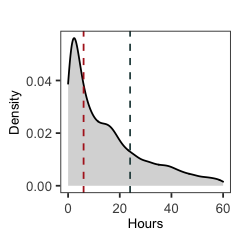

In [238]:
options(repr.plot.width=2, repr.plot.height=2)
p <- output_df %>%
    filter(!grepl(',', pressor)) %>%
    ggplot(aes(x=duration)) +
        base_theme() +
        #geom_histogram(aes(y=..density..), position="identity", alpha=0.5)+
        geom_density(aes(y = ..density..), alpha=0.6, fill="gray")+
        scale_color_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
        scale_fill_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
        labs(title="",x="Hours", y = "Density")+
        xlim(0, 60) +
        geom_vline(xintercept = 6, linetype= "dashed", color="firebrick") +
        geom_vline(xintercept = 24, linetype= "dashed", color="#2F4F4F")
plot(p)

In [241]:
pdf(file.path(PLOT_DIR, "histo_durations.pdf"), 2, 2)
plot(p)
dev.off()

Warning message:
“Removed 967 rows containing non-finite values (stat_density).”


pdf 
  2

Warning message:
“Removed 967 rows containing non-finite values (stat_density).”

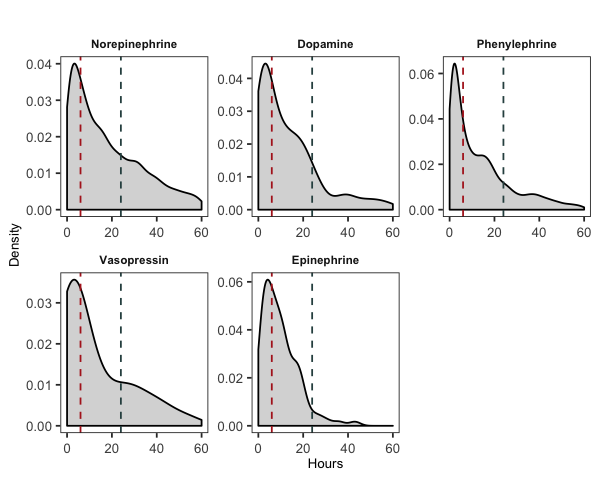

In [222]:
options(repr.plot.width=5, repr.plot.height=4)
p <- output_df %>%
    filter(!grepl(',', pressor)) %>%
    mutate(fancy_pressor = FANCY_PRESSOR_DICT[as.character(pressor)]) %>%
    mutate(fancy_pressor = factor(fancy_pressor, levels=FANCY_PRESSOR_ORDER)) %>%
    ggplot(aes(x=duration)) +
        base_theme() +
        #geom_histogram(aes(y=..density..), position="identity", alpha=0.5)+
        geom_density(aes(y = ..density..), alpha=0.6, fill="gray")+
        scale_color_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
        scale_fill_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
        labs(title="",x="Hours", y = "Density")+
        xlim(0, 60) +
        geom_vline(xintercept = 6, linetype= "dashed", color="firebrick") +
        geom_vline(xintercept = 24, linetype= "dashed", color="#2F4F4F") +
        facet_wrap(. ~fancy_pressor, nrow=2, ncol=3, scale = "free")
plot(p)

In [223]:
pdf(file.path(PLOT_DIR, "histo_individual_durations.pdf"), 5, 4)
plot(p)
dev.off()

Warning message:
“Removed 967 rows containing non-finite values (stat_density).”

pdf 
  2

# CVC Use
- Examine duration
- Examine rate of administration

In [38]:
CVC_COLORS <- c(
"CVC" = '#2F4F4F',
"No CVC" = '#D3D3D3'
)

In [225]:
# <6 hour course
output_df %>%
    filter(!grepl(",", pressor)) %>%
    group_by(RESPONSE = STATUS == "LESSTHAN6HOURS", cvc) %>%
    summarize(COUNT = n(), DURATION = mean(duration)) %>% 
    group_by(RESPONSE) %>%
    mutate(FREQ = COUNT/sum(COUNT))

RESPONSE,cvc,COUNT,DURATION,FREQ
<lgl>,<lgl>,<int>,<drtn>,<dbl>
FALSE,FALSE,1090,21.623073 hours,0.1455468
FALSE,TRUE,6399,34.858165 hours,0.8544532
TRUE,FALSE,760,2.371864 hours,0.1996323
TRUE,TRUE,3047,2.498441 hours,0.8003677


In [226]:
output_df %>%
    group_by(RESPONSE = STATUS == "MORETHAN24HOURS", cvc) %>%
    summarize(COUNT = n()) %>% 
    group_by(RESPONSE) %>%
    mutate(FREQ = COUNT/sum(COUNT))

RESPONSE,cvc,COUNT,FREQ
<lgl>,<lgl>,<int>,<dbl>
FALSE,FALSE,1773,0.18108467
FALSE,TRUE,8018,0.81891533
TRUE,FALSE,501,0.06898926
TRUE,TRUE,6761,0.93101074


In [227]:
output_df %>%
    group_by(RESPONSE = grepl(",", pressor), cvc) %>%
    summarize(COUNT = n()) %>% 
    group_by(RESPONSE) %>%
    mutate(FREQ = COUNT/sum(COUNT))

RESPONSE,cvc,COUNT,FREQ
<lgl>,<lgl>,<int>,<dbl>
FALSE,FALSE,1850,0.16377479
FALSE,TRUE,9446,0.83622521
TRUE,FALSE,424,0.07364947
TRUE,TRUE,5333,0.92635053


In [228]:
pairwise.wilcox.test(as.numeric(output_df$duration), output_df$cvc)


	Pairwise comparisons using Wilcoxon rank sum test 

data:  as.numeric(output_df$duration) and output_df$cvc 

     FALSE 
TRUE <2e-16

P value adjustment method: holm 

Warning message:
“Removed 2448 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 2448 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 2448 rows containing non-finite values (stat_summary).”

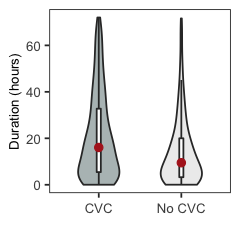

In [229]:
options(repr.plot.width=2, repr.plot.height=2)
p <- output_df %>%
    rowwise() %>%
    mutate(cvc_fancy = if(cvc){"CVC"}else{"No CVC"}) %>%
    mutate(cvc_fancy = factor(cvc_fancy, levels = names(CVC_COLORS))) %>%
    mutate(fancy_pressor = FANCY_PRESSOR_DICT[as.character(pressor)]) %>%
    mutate(fancy_pressor = factor(fancy_pressor, levels=FANCY_PRESSOR_ORDER)) %>%
    ggplot(aes(x=cvc_fancy, y=duration)) +
        base_theme() + 
        theme(legend.position="none") +
        xlab("") +
        ylab("Duration (hours)") +
        geom_violin(aes(fill=cvc_fancy), alpha=0.4, scale="width", trim=TRUE, adjust=2, width=0.5) +
        scale_fill_manual(values=CVC_COLORS) +
        scale_y_continuous(limits=c(0,72)) +
        geom_boxplot(width=0.05, outlier.shape = NA)+
        stat_summary(fun.y=median, geom="point", size=2, color="firebrick")
        #+ facet_grid(. ~fancy_pressor)
plot(p)

In [230]:
pdf(file.path(PLOT_DIR, "cvcduration.pdf"), 2,2)
plot(p)
dev.off()

Warning message:
“Removed 2448 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 2448 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 2448 rows containing non-finite values (stat_summary).”

pdf 
  2

In [231]:
for(pressor_choice in FANCY_PRESSOR_ORDER){
    print(pressor_choice)
    pairwise.wilcox.test(as.numeric(filter(output_df,pressor==pressor_choice)$duration), 
                     filter(output_df,pressor==pressor_choice)$cvc) %>% 
    print()
}

[1] "Norepinephrine"

	Pairwise comparisons using Wilcoxon rank sum test 

data:  as.numeric(filter(output_df, pressor == pressor_choice)$duration) and filter(output_df, pressor == pressor_choice)$cvc 

     FALSE 
TRUE <2e-16

P value adjustment method: holm 
[1] "Dopamine"

	Pairwise comparisons using Wilcoxon rank sum test 

data:  as.numeric(filter(output_df, pressor == pressor_choice)$duration) and filter(output_df, pressor == pressor_choice)$cvc 

     FALSE
TRUE 0.012

P value adjustment method: holm 
[1] "Phenylephrine"

	Pairwise comparisons using Wilcoxon rank sum test 

data:  as.numeric(filter(output_df, pressor == pressor_choice)$duration) and filter(output_df, pressor == pressor_choice)$cvc 

     FALSE  
TRUE 0.00027

P value adjustment method: holm 
[1] "Vasopressin"

	Pairwise comparisons using Wilcoxon rank sum test 

data:  as.numeric(filter(output_df, pressor == pressor_choice)$duration) and filter(output_df, pressor == pressor_choice)$cvc 

     FALSE
TRUE 0.59 

P

Warning message:
“Removed 657 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 657 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 657 rows containing non-finite values (stat_summary).”

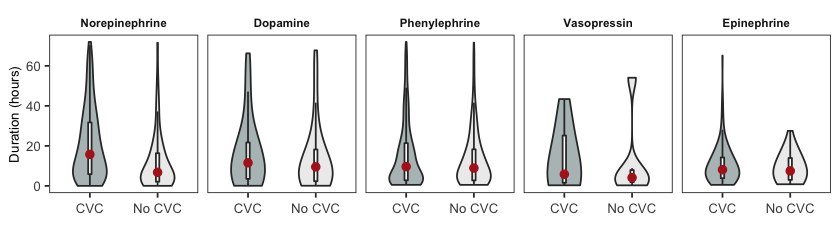

In [232]:
options(repr.plot.width=7, repr.plot.height=2)
p <- output_df %>%
    filter(!grepl(",", pressor)) %>%
    rowwise() %>%
    mutate(cvc_fancy = if(cvc){"CVC"}else{"No CVC"}) %>%
    mutate(cvc_fancy = factor(cvc_fancy, levels = names(CVC_COLORS))) %>%
    mutate(fancy_pressor = FANCY_PRESSOR_DICT[as.character(pressor)]) %>%
    mutate(fancy_pressor = factor(fancy_pressor, levels=FANCY_PRESSOR_ORDER)) %>%
    ggplot(aes(x=cvc_fancy, y=duration)) +
        base_theme() + 
        theme(legend.position="none") +
        xlab("") +
        ylab("Duration (hours)") +
        geom_violin(aes(fill=cvc_fancy), alpha=0.4, scale="width", trim=TRUE, adjust=2, width=0.5) +
        scale_fill_manual(values=CVC_COLORS) +
        scale_y_continuous(limits=c(0,72)) +
        geom_boxplot(width=0.05, outlier.shape = NA) +
        stat_summary(fun.y=median, geom="point", size=2, color="firebrick") +
        facet_grid(. ~fancy_pressor)
plot(p)

### Lactate levels

In [224]:
CVC_COLORS <- c(
"CVC" = '#2F4F4F',
"No CVC" = '#D3D3D3'
)

In [225]:
# <6 hour course
output_df %>%
    filter(!grepl(",", pressor)) %>%
    group_by(RESPONSE = STATUS == "LESSTHAN6HOURS", cvc) %>%
    summarize(COUNT = n(), DURATION = mean(duration)) %>% 
    group_by(RESPONSE) %>%
    mutate(FREQ = COUNT/sum(COUNT))

RESPONSE,cvc,COUNT,DURATION,FREQ
<lgl>,<lgl>,<int>,<drtn>,<dbl>
FALSE,FALSE,1090,21.623073 hours,0.1455468
FALSE,TRUE,6399,34.858165 hours,0.8544532
TRUE,FALSE,760,2.371864 hours,0.1996323
TRUE,TRUE,3047,2.498441 hours,0.8003677


In [226]:
output_df %>%
    group_by(RESPONSE = STATUS == "MORETHAN24HOURS", cvc) %>%
    summarize(COUNT = n()) %>% 
    group_by(RESPONSE) %>%
    mutate(FREQ = COUNT/sum(COUNT))

RESPONSE,cvc,COUNT,FREQ
<lgl>,<lgl>,<int>,<dbl>
FALSE,FALSE,1773,0.18108467
FALSE,TRUE,8018,0.81891533
TRUE,FALSE,501,0.06898926
TRUE,TRUE,6761,0.93101074


In [227]:
output_df %>%
    group_by(RESPONSE = grepl(",", pressor), cvc) %>%
    summarize(COUNT = n()) %>% 
    group_by(RESPONSE) %>%
    mutate(FREQ = COUNT/sum(COUNT))

RESPONSE,cvc,COUNT,FREQ
<lgl>,<lgl>,<int>,<dbl>
FALSE,FALSE,1850,0.16377479
FALSE,TRUE,9446,0.83622521
TRUE,FALSE,424,0.07364947
TRUE,TRUE,5333,0.92635053


In [228]:
pairwise.wilcox.test(as.numeric(output_df$duration), output_df$cvc)


	Pairwise comparisons using Wilcoxon rank sum test 

data:  as.numeric(output_df$duration) and output_df$cvc 

     FALSE 
TRUE <2e-16

P value adjustment method: holm 

Warning message:
“Removed 2448 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 2448 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 2448 rows containing non-finite values (stat_summary).”

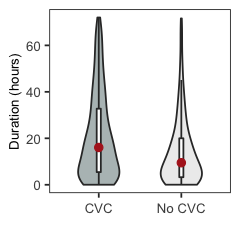

In [229]:
options(repr.plot.width=2, repr.plot.height=2)
p <- output_df %>%
    rowwise() %>%
    mutate(cvc_fancy = if(cvc){"CVC"}else{"No CVC"}) %>%
    mutate(cvc_fancy = factor(cvc_fancy, levels = names(CVC_COLORS))) %>%
    mutate(fancy_pressor = FANCY_PRESSOR_DICT[as.character(pressor)]) %>%
    mutate(fancy_pressor = factor(fancy_pressor, levels=FANCY_PRESSOR_ORDER)) %>%
    ggplot(aes(x=cvc_fancy, y=duration)) +
        base_theme() + 
        theme(legend.position="none") +
        xlab("") +
        ylab("Duration (hours)") +
        geom_violin(aes(fill=cvc_fancy), alpha=0.4, scale="width", trim=TRUE, adjust=2, width=0.5) +
        scale_fill_manual(values=CVC_COLORS) +
        scale_y_continuous(limits=c(0,72)) +
        geom_boxplot(width=0.05, outlier.shape = NA)+
        stat_summary(fun.y=median, geom="point", size=2, color="firebrick")
        #+ facet_grid(. ~fancy_pressor)
plot(p)

In [230]:
pdf(file.path(PLOT_DIR, "cvcduration.pdf"), 2,2)
plot(p)
dev.off()

Warning message:
“Removed 2448 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 2448 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 2448 rows containing non-finite values (stat_summary).”

pdf 
  2

In [231]:
for(pressor_choice in FANCY_PRESSOR_ORDER){
    print(pressor_choice)
    pairwise.wilcox.test(as.numeric(filter(output_df,pressor==pressor_choice)$duration), 
                     filter(output_df,pressor==pressor_choice)$cvc) %>% 
    print()
}

[1] "Norepinephrine"

	Pairwise comparisons using Wilcoxon rank sum test 

data:  as.numeric(filter(output_df, pressor == pressor_choice)$duration) and filter(output_df, pressor == pressor_choice)$cvc 

     FALSE 
TRUE <2e-16

P value adjustment method: holm 
[1] "Dopamine"

	Pairwise comparisons using Wilcoxon rank sum test 

data:  as.numeric(filter(output_df, pressor == pressor_choice)$duration) and filter(output_df, pressor == pressor_choice)$cvc 

     FALSE
TRUE 0.012

P value adjustment method: holm 
[1] "Phenylephrine"

	Pairwise comparisons using Wilcoxon rank sum test 

data:  as.numeric(filter(output_df, pressor == pressor_choice)$duration) and filter(output_df, pressor == pressor_choice)$cvc 

     FALSE  
TRUE 0.00027

P value adjustment method: holm 
[1] "Vasopressin"

	Pairwise comparisons using Wilcoxon rank sum test 

data:  as.numeric(filter(output_df, pressor == pressor_choice)$duration) and filter(output_df, pressor == pressor_choice)$cvc 

     FALSE
TRUE 0.59 

P

Warning message:
“Removed 657 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 657 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 657 rows containing non-finite values (stat_summary).”

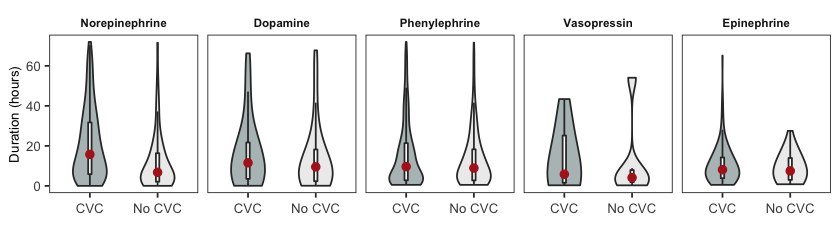

In [232]:
options(repr.plot.width=7, repr.plot.height=2)
p <- output_df %>%
    filter(!grepl(",", pressor)) %>%
    rowwise() %>%
    mutate(cvc_fancy = if(cvc){"CVC"}else{"No CVC"}) %>%
    mutate(cvc_fancy = factor(cvc_fancy, levels = names(CVC_COLORS))) %>%
    mutate(fancy_pressor = FANCY_PRESSOR_DICT[as.character(pressor)]) %>%
    mutate(fancy_pressor = factor(fancy_pressor, levels=FANCY_PRESSOR_ORDER)) %>%
    ggplot(aes(x=cvc_fancy, y=duration)) +
        base_theme() + 
        theme(legend.position="none") +
        xlab("") +
        ylab("Duration (hours)") +
        geom_violin(aes(fill=cvc_fancy), alpha=0.4, scale="width", trim=TRUE, adjust=2, width=0.5) +
        scale_fill_manual(values=CVC_COLORS) +
        scale_y_continuous(limits=c(0,72)) +
        geom_boxplot(width=0.05, outlier.shape = NA) +
        stat_summary(fun.y=median, geom="point", size=2, color="firebrick") +
        facet_grid(. ~fancy_pressor)
plot(p)

### Lactate levels and duration

In [227]:
output_df %>%
    left_join(lactate) %>% dim()

Joining, by = c("hadm_id", "subject_id")



[1] 17053    25

In [228]:
output_df %>%
    left_join(lactate) %>% drop_na(value) %>% dim()

Joining, by = c("hadm_id", "subject_id")



[1] 16179    25

In [230]:
(17053 - 16179)/17053

[1] 0.05125198

Joining, by = c("hadm_id", "subject_id")
Warning message:
“Removed 184 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 184 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 184 rows containing non-finite values (stat_summary).”

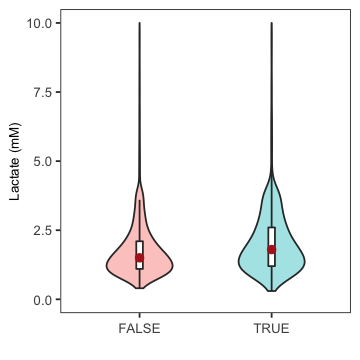

In [391]:
p <- output_df %>%
    left_join(lactate) %>%
    group_by(RESPONSE = STATUS == "MORETHAN24HOURS") %>%
    drop_na(value) %>%
    ggplot(aes(x=RESPONSE, y=value)) +
        base_theme() + 
        theme(legend.position="none") +
        xlab("") +
        ylab("Lactate (mM)") +
        geom_violin(aes(fill=RESPONSE), alpha=0.4, scale="width", trim=TRUE, adjust=2, width=0.5) +
        #scale_fill_manual(values=CVC_COLORS) +
        scale_y_continuous(limits=c(0,10)) +
        geom_boxplot(width=0.05, outlier.shape = NA)+
        stat_summary(fun.y=median, geom="point", size=2, color="firebrick")
        #+ facet_grid(. ~fancy_pressor)
plot(p)

Joining, by = c("hadm_id", "subject_id")
Warning message:
“Removed 184 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 184 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 184 rows containing non-finite values (stat_summary).”

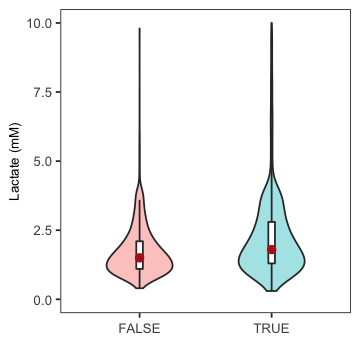

In [396]:
p <- output_df %>%
    left_join(lactate) %>%
    group_by(RESPONSE = grepl(",", pressor)) %>%
    drop_na(value) %>%
    ggplot(aes(x=RESPONSE, y=value)) +
        base_theme() + 
        theme(legend.position="none") +
        xlab("") +
        ylab("Lactate (mM)") +
        geom_violin(aes(fill=RESPONSE), alpha=0.4, scale="width", trim=TRUE, adjust=2, width=0.5) +
        #scale_fill_manual(values=CVC_COLORS) +
        scale_y_continuous(limits=c(0,10)) +
        geom_boxplot(width=0.05, outlier.shape = NA)+
        stat_summary(fun.y=median, geom="point", size=2, color="firebrick")
        #+ facet_grid(. ~fancy_pressor)
plot(p)

### Amount of fluid administered

In [32]:
inputfluid_df %>% head()

subject_id,hadm_id,stay_id,amount
<dbl>,<dbl>,<dbl>,<dbl>
10000032,29079034,37529680,400.0000
10000980,26913865,36742749,469.4778
10001217,24597018,30327812,3147.2500
10001217,27703517,30514987,2661.6667
10001725,25563031,37542711,3464.6667
10001884,26184834,31832304,9689.8718


In [156]:
head(inputfluid_df)

subject_id,hadm_id,stay_id,amount
<dbl>,<dbl>,<dbl>,<dbl>
10000032,29079034,37529680,400.0000
10000980,26913865,36742749,469.4778
10001217,24597018,30327812,3147.2500
10001217,27703517,30514987,2661.6667
10001725,25563031,37542711,3464.6667
10001884,26184834,31832304,9689.8718


Joining, by = c("hadm_id", "subject_id", "stay_id")

Warning message:
“`fun.y` is deprecated. Use `fun` instead.”
Warning message:
“Removed 570 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 570 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 570 rows containing non-finite values (stat_summary).”


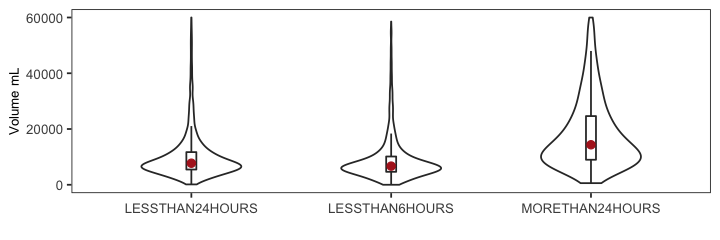

In [36]:
options(repr.plot.width=6, repr.plot.height=2)
p <- output_df %>% 
    left_join(inputfluid_df) %>%
    rowwise() %>%
    mutate(fancy_pressor = FANCY_PRESSOR_DICT[as.character(pressor)]) %>%
    mutate(fancy_pressor = factor(fancy_pressor, levels=FANCY_PRESSOR_ORDER)) %>%
    ggplot(aes(x=STATUS, y=amount)) +
        base_theme() + 
        theme(legend.position="none") +
        xlab("") +
        ylab("Volume mL") +
        geom_violin(alpha=0.4, scale="width", trim=TRUE, adjust=2, width=0.5) +
        #scale_fill_manual(values=CVC_COLORS) +
        scale_y_continuous(limits=c(0,60000)) +
        geom_boxplot(width=0.05, outlier.shape = NA)+
        stat_summary(fun.y=median, geom="point", size=2, color="firebrick")
        #+ facet_grid(. ~fancy_pressor)
plot(p)

Joining, by = c("hadm_id", "subject_id", "stay_id")
Warning message:
“Removed 466 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 466 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 466 rows containing non-finite values (stat_summary).”

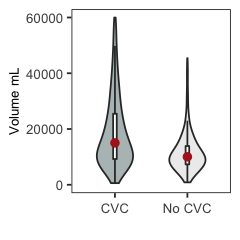

In [470]:
options(repr.plot.width=2, repr.plot.height=2)
p <- output_df %>% 
    left_join(inputfluid_df) %>%
    filter(STATUS == "MORETHAN24HOURS") %>%
    rowwise() %>%
    mutate(cvc_fancy = if(cvc){"CVC"}else{"No CVC"}) %>%
    mutate(cvc_fancy = factor(cvc_fancy, levels = names(CVC_COLORS))) %>%
    mutate(fancy_pressor = FANCY_PRESSOR_DICT[as.character(pressor)]) %>%
    mutate(fancy_pressor = factor(fancy_pressor, levels=FANCY_PRESSOR_ORDER)) %>%
    ggplot(aes(x=cvc_fancy, y=amount)) +
        base_theme() + 
        theme(legend.position="none") +
        xlab("") +
        ylab("Volume mL") +
        geom_violin(aes(fill=cvc_fancy), alpha=0.4, scale="width", trim=TRUE, adjust=2, width=0.5) +
        scale_fill_manual(values=CVC_COLORS) +
        scale_y_continuous(limits=c(0,60000)) +
        geom_boxplot(width=0.05, outlier.shape = NA)+
        stat_summary(fun.y=median, geom="point", size=2, color="firebrick")
        #+ facet_grid(. ~fancy_pressor)
plot(p)

Joining, by = c("hadm_id", "subject_id", "stay_id")
Warning message:
“Removed 360 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 360 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 360 rows containing non-finite values (stat_summary).”

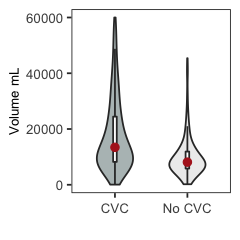

In [471]:
options(repr.plot.width=2, repr.plot.height=2)
p <- output_df %>% 
    left_join(inputfluid_df) %>%
    filter(grepl(",", pressor)) %>%
    rowwise() %>%
    mutate(cvc_fancy = if(cvc){"CVC"}else{"No CVC"}) %>%
    mutate(cvc_fancy = factor(cvc_fancy, levels = names(CVC_COLORS))) %>%
    mutate(fancy_pressor = FANCY_PRESSOR_DICT[as.character(pressor)]) %>%
    mutate(fancy_pressor = factor(fancy_pressor, levels=FANCY_PRESSOR_ORDER)) %>%
    ggplot(aes(x=cvc_fancy, y=amount)) +
        base_theme() + 
        theme(legend.position="none") +
        xlab("") +
        ylab("Volume mL") +
        geom_violin(aes(fill=cvc_fancy), alpha=0.4, scale="width", trim=TRUE, adjust=2, width=0.5) +
        scale_fill_manual(values=CVC_COLORS) +
        scale_y_continuous(limits=c(0,60000)) +
        geom_boxplot(width=0.05, outlier.shape = NA)+
        stat_summary(fun.y=median, geom="point", size=2, color="firebrick")
        #+ facet_grid(. ~fancy_pressor)
plot(p)

Joining, by = c("hadm_id", "subject_id", "stay_id")
Warning message:
“Removed 321 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 321 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 321 rows containing non-finite values (stat_summary).”

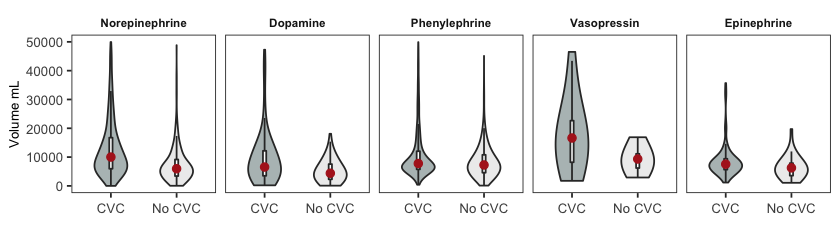

In [467]:
options(repr.plot.width=7, repr.plot.height=2)
p <- output_df %>% 
    left_join(inputfluid_df) %>%
    rowwise() %>%
    mutate(cvc_fancy = if(cvc){"CVC"}else{"No CVC"}) %>%
    mutate(cvc_fancy = factor(cvc_fancy, levels = names(CVC_COLORS))) %>%
    mutate(fancy_pressor = FANCY_PRESSOR_DICT[as.character(pressor)]) %>%
    mutate(fancy_pressor = factor(fancy_pressor, levels=FANCY_PRESSOR_ORDER)) %>%
    drop_na(fancy_pressor) %>%
    ggplot(aes(x=cvc_fancy, y=amount)) +
        base_theme() + 
        theme(legend.position="none") +
        xlab("") +
        ylab("Volume mL") +
        geom_violin(aes(fill=cvc_fancy), alpha=0.4, scale="width", trim=TRUE, adjust=2, width=0.5) +
        scale_fill_manual(values=CVC_COLORS) +
        scale_y_continuous(limits=c(0,50000)) +
        geom_boxplot(width=0.05, outlier.shape = NA)+
        stat_summary(fun.y=median, geom="point", size=2, color="firebrick")+
        facet_grid(. ~fancy_pressor)
plot(p)

### Rate of vasopressor

In [44]:
output_df %>% 
    drop_na(rate) %>%
    dim()

[1] 17053    24

Warning message:
“`fun.y` is deprecated. Use `fun` instead.”
Warning message:
“Removed 25 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 25 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 25 rows containing non-finite values (stat_summary).”


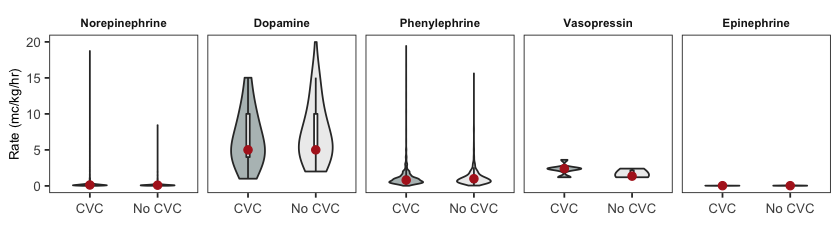

In [52]:
options(repr.plot.width=7, repr.plot.height=2)
p <- output_df %>%
    rowwise() %>%
    mutate(cvc_fancy = if(cvc){"CVC"}else{"No CVC"}) %>%
    mutate(cvc_fancy = factor(cvc_fancy, levels = names(CVC_COLORS))) %>%
    mutate(fancy_pressor = FANCY_PRESSOR_DICT[as.character(pressor)]) %>%
    mutate(fancy_pressor = factor(fancy_pressor, levels=FANCY_PRESSOR_ORDER)) %>%
    drop_na(fancy_pressor) %>%
    ggplot(aes(x=cvc_fancy, y=rate)) +
        base_theme() + 
        theme(legend.position="none") +
        xlab("") +
        ylab("Rate (mc/kg/hr)") +
        geom_violin(aes(fill=cvc_fancy), alpha=0.4, scale="width", trim=TRUE, adjust=2, width=0.5) +
        scale_fill_manual(values=CVC_COLORS) +
        scale_y_continuous(limits=c(0,20)) +
        geom_boxplot(width=0.05, outlier.shape = NA)+
        stat_summary(fun.y=median, geom="point", size=2, color="firebrick") +
        facet_grid(. ~fancy_pressor)
plot(p)

In [50]:
for(pressor_choice in FANCY_PRESSOR_ORDER){
    print(pressor_choice)
    pairwise.wilcox.test(as.numeric(filter(output_df,pressor==pressor_choice)$rate), 
                     filter(output_df,pressor==pressor_choice)$cvc) %>% 
    print()
}

[1] "Norepinephrine"

	Pairwise comparisons using Wilcoxon rank sum test with continuity correction 

data:  as.numeric(filter(output_df, pressor == pressor_choice)$rate) and filter(output_df, pressor == pressor_choice)$cvc 

     FALSE  
TRUE 8.5e-13

P value adjustment method: holm 
[1] "Dopamine"

	Pairwise comparisons using Wilcoxon rank sum test with continuity correction 

data:  as.numeric(filter(output_df, pressor == pressor_choice)$rate) and filter(output_df, pressor == pressor_choice)$cvc 

     FALSE
TRUE 0.27 

P value adjustment method: holm 
[1] "Phenylephrine"

	Pairwise comparisons using Wilcoxon rank sum test with continuity correction 

data:  as.numeric(filter(output_df, pressor == pressor_choice)$rate) and filter(output_df, pressor == pressor_choice)$cvc 

     FALSE
TRUE 0.028

P value adjustment method: holm 
[1] "Vasopressin"


Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with ties”



	Pairwise comparisons using Wilcoxon rank sum test with continuity correction 

data:  as.numeric(filter(output_df, pressor == pressor_choice)$rate) and filter(output_df, pressor == pressor_choice)$cvc 

     FALSE
TRUE 0.053

P value adjustment method: holm 
[1] "Epinephrine"

	Pairwise comparisons using Wilcoxon rank sum test with continuity correction 

data:  as.numeric(filter(output_df, pressor == pressor_choice)$rate) and filter(output_df, pressor == pressor_choice)$cvc 

     FALSE
TRUE 0.03 

P value adjustment method: holm 


Warning message:
“Removed 1462 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 1462 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 1462 rows containing non-finite values (stat_summary).”

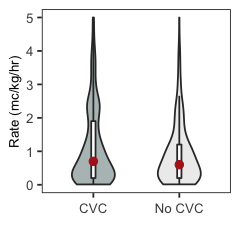

In [451]:
options(repr.plot.width=2, repr.plot.height=2)
p <- output_df %>%
    rowwise() %>%
    mutate(cvc_fancy = if(cvc){"CVC"}else{"No CVC"}) %>%
    mutate(cvc_fancy = factor(cvc_fancy, levels = names(CVC_COLORS))) %>%
    mutate(fancy_pressor = FANCY_PRESSOR_DICT[as.character(pressor)]) %>%
    mutate(fancy_pressor = factor(fancy_pressor, levels=FANCY_PRESSOR_ORDER)) %>%
    ggplot(aes(x=cvc_fancy, y=rate)) +
        base_theme() + 
        theme(legend.position="none") +
        xlab("") +
        ylab("Rate (mc/kg/hr)") +
        geom_violin(aes(fill=cvc_fancy), alpha=0.4, scale="width", trim=TRUE, adjust=2, width=0.5) +
        scale_fill_manual(values=CVC_COLORS) +
        scale_y_continuous(limits=c(0,5)) +
        geom_boxplot(width=0.05, outlier.shape = NA)+
        stat_summary(fun.y=median, geom="point", size=2, color="firebrick")
        #+ facet_grid(. ~fancy_pressor)
plot(p)

### Summary tables

In [234]:
head(output_df)

course_id,PATIENT,simple_diagnosis,age,intub,first_careunit,ed_admission,creatinine,gender,stay_id,starttime,endtime,pressor,duration,age_cohort,cvc,MORETHAN24HOURS,STATUS,RESPONSE
<chr>,<dbl>,<chr>,<dbl>,<lgl>,<chr>,<lgl>,<lgl>,<chr>,<dbl>,<dttm>,<dttm>,<chr>,<drtn>,<dbl>,<lgl>,<lgl>,<chr>,<lgl>
"30000010,0",16939016,CARDIAC,65,TRUE,Cardiac Vascular Intensive Care Unit (CVICU),FALSE,TRUE,M,30000010,2166-12-20 13:01:00,2166-12-20 13:49:00,Phenylephrine,0.800000 hours,60,TRUE,FALSE,LESSTHAN6HOURS,FALSE
"30001276,0",19299142,OTHER DIAGNOSIS,87,FALSE,Medical Intensive Care Unit (MICU),TRUE,TRUE,F,30001276,2143-07-17 18:38:00,2143-07-17 21:11:00,"Norepinephrine,Phenylephrine",2.550000 hours,90,TRUE,FALSE,LESSTHAN6HOURS,TRUE
"30001535,0",14247396,INFECTION,69,TRUE,Neuro Surgical Intensive Care Unit (Neuro SICU),FALSE,FALSE,M,30001535,2177-11-17 21:00:00,2177-11-18 11:17:00,Norepinephrine,14.283333 hours,70,FALSE,FALSE,LESSTHAN24HOURS,FALSE
"30001939,0",19023641,OTHER DIAGNOSIS,47,TRUE,Medical/Surgical Intensive Care Unit (MICU/SICU),TRUE,FALSE,M,30001939,2151-04-06 16:53:00,2151-04-15 15:30:00,"Norepinephrine,Vasopressin,Dopamine",214.616667 hours,50,TRUE,TRUE,MORETHAN24HOURS,TRUE
"30002055,0",10887901,OTHER DIAGNOSIS,69,TRUE,Medical Intensive Care Unit (MICU),FALSE,FALSE,M,30002055,2171-09-26 14:00:00,2171-10-05 22:44:00,"Epinephrine,Norepinephrine,Vasopressin,Phenylephrine",224.733333 hours,70,TRUE,TRUE,MORETHAN24HOURS,TRUE
"30002198,0",18823151,OTHER DIAGNOSIS,55,TRUE,Medical/Surgical Intensive Care Unit (MICU/SICU),TRUE,FALSE,M,30002198,2145-01-05 07:20:00,2145-01-05 11:45:00,Phenylephrine,4.416667 hours,60,TRUE,FALSE,LESSTHAN6HOURS,FALSE


In [235]:
total_df <- output_df %>%
    summarize(
            TOTAL = "TOTAL",
            n = paste(round(as.numeric(n()),2)), 
            Age = paste(round(as.numeric(mean(age, na.rm=TRUE)),2), paste0('(SD=', sd(age, na.rm=TRUE) %>% round(2),')')), 
            Male = paste(sum(gender == 'M')),
            MICU = paste(sum(first_careunit == 'Medical Intensive Care Unit (MICU)')),
            SICU = paste(sum(first_careunit == 'Surgical Intensive Care Unit (SICU)')),
            CCU = paste(sum(first_careunit == 'Cardiac Vascular Intensive Care Unit (CVICU)')),
            TSICU = paste(sum(first_careunit == 'Trauma SICU (TSICU)')),
            MSICU = paste(sum(first_careunit == 'Medical/Surgical Intensive Care Unit (MICU/SICU)')),
            NSICU = paste(sum(first_careunit == 'Neuro Surgical Intensive Care Unit (Neuro SICU)')),
            Infectious_Diagnosis = paste(sum(simple_diagnosis == "INFECTION")),
            Cardiac_Diagnosis = paste(sum(simple_diagnosis == "CARDIAC")),
            Other_Diagnosis = paste(sum(simple_diagnosis == "OTHER DIAGNOSIS")),
            Intubated = paste(sum(intub == "TRUE")),
            Renal_Impairment = paste(sum(creatinine == "TRUE")),
            ED_Admission = paste(sum(ed_admission == "TRUE"))
             ) %>% t()

In [236]:
output_df %>%
    group_by(simple_diagnosis) %>%
    summarize(COUNT = n())

simple_diagnosis,COUNT
<chr>,<int>
CARDIAC,3075
INFECTION,2938
OTHER DIAGNOSIS,11040


In [237]:
colnames(total_df) <- "TOTAL"

In [238]:
total_df

,TOTAL
TOTAL,TOTAL
n,17053
Age,65.16 (SD=14.45)
Male,10366
MICU,3729
SICU,2168
CCU,6337
TSICU,2053
MSICU,2430
NSICU,336


In [242]:
sum_df <- output_df %>% 
    rowwise() %>%
    mutate(STATUS = if(grepl(",", pressor)){"MULTI"}else{STATUS}) %>%
    group_by(STATUS) %>%
    summarize(
            n = n(), 
            Age = paste(round(as.numeric(mean(age, na.rm=TRUE)),2), paste0('(SD=', sd(age, na.rm=TRUE) %>% round(2),')')),
            Male = sum(gender == 'M'),
            MICU = sum(first_careunit == 'Medical Intensive Care Unit (MICU)'),
            SICU = sum(first_careunit == 'Surgical Intensive Care Unit (SICU)'),
            CCU = sum(first_careunit == 'Cardiac Vascular Intensive Care Unit (CVICU)'),
            TSICU = sum(first_careunit == 'Trauma SICU (TSICU)'),
            MSICU =sum(first_careunit == 'Medical/Surgical Intensive Care Unit (MICU/SICU)'),
            NSICU = sum(first_careunit == 'Neuro Surgical Intensive Care Unit (Neuro SICU)'),
            Infectious_Diagnosis = sum(simple_diagnosis == "INFECTION"),
            Cardiac_Diagnosis = sum(simple_diagnosis == "CARDIAC"),
            Other_Diagnosis = sum(simple_diagnosis == "OTHER DIAGNOSIS"),
            Intubated = sum(intub == "TRUE"),
            Renal_Impairment = sum(creatinine == "TRUE"),
            ED_Admission = sum(ed_admission == "TRUE")) 

Warning message:
“Grouping rowwise data frame strips rowwise nature”

In [243]:
sum_df

STATUS,n,Age,Male,MICU,SICU,CCU,TSICU,MSICU,NSICU,Infectious_Diagnosis,Cardiac_Diagnosis,Other_Diagnosis,Intubated,Renal_Impairment,ED_Admission
<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
LESSTHAN24HOURS,4145,64.66 (SD=14.2),2613,771,499,1692,481,603,99,643,920,2582,3044,1145,1539
LESSTHAN6HOURS,3807,65.97 (SD=14.18),2344,586,441,1897,369,454,60,440,984,2383,3025,967,1281
MORETHAN24HOURS,3344,64.58 (SD=14.9),1910,934,513,788,495,540,74,720,414,2210,2476,1261,1534
MULTI,5757,65.32 (SD=14.52),3499,1438,715,1960,708,833,103,1135,757,3865,5055,2656,2328


In [244]:
t1_df <- sum_df %>%
    ungroup() %>%
    mutate(
        n = paste(round(n,2), paste0('(', 100*(n/sum(n)) %>% round(3), '%)')),
        Male = paste(round(Male,2), paste0('(', 100*(Male/sum(Male)) %>% round(3), '%)')),
        MICU = paste(round(MICU,2), paste0('(', 100*(MICU/sum(MICU)) %>% round(3), '%)')),
        SICU = paste(round(SICU,2), paste0('(', 100*(SICU/sum(SICU)) %>% round(3), '%)')),
        CCU = paste(round(CCU,2), paste0('(', 100*(CCU/sum(CCU)) %>% round(3), '%)')),
        TSICU = paste(round(TSICU,2), paste0('(', 100*(TSICU/sum(TSICU)) %>% round(3), '%)')),
        MSICU = paste(round(MSICU,2), paste0('(', 100*(MSICU/sum(MSICU)) %>% round(3), '%)')),
        NSICU = paste(round(NSICU,2), paste0('(', 100*(NSICU/sum(NSICU)) %>% round(3), '%)')),
        Infectious_Diagnosis = paste(round(Infectious_Diagnosis,2), paste0('(', 100*(Infectious_Diagnosis/sum(Infectious_Diagnosis)) %>% round(3), '%)')),
        Cardiac_Diagnosis = paste(round(Cardiac_Diagnosis,2), paste0('(', 100*(Cardiac_Diagnosis/sum(Cardiac_Diagnosis)) %>% round(3), '%)')),
        Other_Diagnosis = paste(round(Other_Diagnosis,2), paste0('(', 100*(Other_Diagnosis/sum(Other_Diagnosis)) %>% round(3), '%)')),
        Intubated = paste(round(Intubated,2), paste0('(', 100*(Intubated/sum(Intubated)) %>% round(3), '%)')),
        Renal_Impairment = paste(round(Renal_Impairment,2), paste0('(', 100*(Renal_Impairment/sum(Renal_Impairment)) %>% round(3), '%)')),
        ED_Admission = paste(round(ED_Admission,2), paste0('(', 100*(ED_Admission/sum(ED_Admission)) %>% round(3), '%)'))
    ) %>% t()

In [245]:
colnames(t1_df) <- t1_df[1,]

In [246]:
t1_df

,LESSTHAN24HOURS,LESSTHAN6HOURS,MORETHAN24HOURS,MULTI
STATUS,LESSTHAN24HOURS,LESSTHAN6HOURS,MORETHAN24HOURS,MULTI
n,4145 (24.3%),3807 (22.3%),3344 (19.6%),5757 (33.8%)
Age,64.66 (SD=14.2),65.97 (SD=14.18),64.58 (SD=14.9),65.32 (SD=14.52)
Male,2613 (25.2%),2344 (22.6%),1910 (18.4%),3499 (33.8%)
MICU,771 (20.7%),586 (15.7%),934 (25%),1438 (38.6%)
SICU,499 (23%),441 (20.3%),513 (23.7%),715 (33%)
CCU,1692 (26.7%),1897 (29.9%),788 (12.4%),1960 (30.9%)
TSICU,481 (23.4%),369 (18%),495 (24.1%),708 (34.5%)
MSICU,603 (24.8%),454 (18.7%),540 (22.2%),833 (34.3%)
NSICU,99 (29.5%),60 (17.9%),74 (22%),103 (30.7%)


In [247]:
cbind(total_df,t1_df) %>% write.csv(file.path(PLOT_DIR, "response_demographics.csv"))

In [248]:
s1_3_df <- output_df %>% 
    filter(!grepl(",", pressor)) %>%
    group_by(STATUS, pressor) %>%
    summarize(
            n = n(), 
            Age = paste(round(as.numeric(mean(age, na.rm=TRUE)),2), paste0('(SD=', sd(age, na.rm=TRUE) %>% round(2),')')),
            Male = sum(gender == 'M'),
            MICU = sum(first_careunit == 'Medical Intensive Care Unit (MICU)'),
            SICU = sum(first_careunit == 'Surgical Intensive Care Unit (SICU)'),
            CCU = sum(first_careunit == 'Cardiac Vascular Intensive Care Unit (CVICU)'),
            TSICU = sum(first_careunit == 'Trauma SICU (TSICU)'),
            MSICU =sum(first_careunit == 'Medical/Surgical Intensive Care Unit (MICU/SICU)'),
            NSICU = sum(first_careunit == 'Neuro Surgical Intensive Care Unit (Neuro SICU)'),
            Infectious_Diagnosis = sum(simple_diagnosis == "INFECTION"),
            Cardiac_Diagnosis = sum(simple_diagnosis == "CARDIAC"),
            Other_Diagnosis = sum(simple_diagnosis == "OTHER DIAGNOSIS"),
            Intubated = sum(intub == "TRUE"),
            Renal_Impairment = sum(creatinine == "TRUE"),
            ED_Admission = sum(ed_admission == "TRUE")) %>%
    ungroup() %>%
    group_by(pressor) %>%
    mutate(
        n = paste(round(n,2), paste0('(', 100*(n/sum(n)) %>% round(3), '%)')),
        Male = paste(round(Male,2), paste0('(', 100*(Male/sum(Male)) %>% round(3), '%)')),
        MICU = paste(round(MICU,2), paste0('(', 100*(MICU/sum(MICU)) %>% round(3), '%)')),
        SICU = paste(round(SICU,2), paste0('(', 100*(SICU/sum(SICU)) %>% round(3), '%)')),
        CCU = paste(round(CCU,2), paste0('(', 100*(CCU/sum(CCU)) %>% round(3), '%)')),
        TSICU = paste(round(TSICU,2), paste0('(', 100*(TSICU/sum(TSICU)) %>% round(3), '%)')),
        MSICU = paste(round(MSICU,2), paste0('(', 100*(MSICU/sum(MSICU)) %>% round(3), '%)')),
        NSICU = paste(round(NSICU,2), paste0('(', 100*(NSICU/sum(NSICU)) %>% round(3), '%)')),
        Infectious_Diagnosis = paste(round(Infectious_Diagnosis,2), paste0('(', 100*(Infectious_Diagnosis/sum(Infectious_Diagnosis)) %>% round(3), '%)')),
        Cardiac_Diagnosis = paste(round(Cardiac_Diagnosis,2), paste0('(', 100*(Cardiac_Diagnosis/sum(Cardiac_Diagnosis)) %>% round(3), '%)')),
        Other_Diagnosis = paste(round(Other_Diagnosis,2), paste0('(', 100*(Other_Diagnosis/sum(Other_Diagnosis)) %>% round(3), '%)')),
        Intubated = paste(round(Intubated,2), paste0('(', 100*(Intubated/sum(Intubated)) %>% round(3), '%)')),
        Renal_Impairment = paste(round(Renal_Impairment,2), paste0('(', 100*(Renal_Impairment/sum(Renal_Impairment)) %>% round(3), '%)')),
        ED_Admission = paste(round(ED_Admission,2), paste0('(', 100*(ED_Admission/sum(ED_Admission)) %>% round(3), '%)'))
    ) 

In [249]:
for(pressor_choice in FANCY_PRESSOR_ORDER){
    out_df <- s1_3_df %>%
        filter(pressor == pressor_choice) %>%
        ungroup() %>%
        t()
    colnames(out_df) <- out_df[1,]
    out_df %>% 
        data.frame() %>%
        select(LESSTHAN6HOURS, LESSTHAN24HOURS, MORETHAN24HOURS) %>%
        write.csv(file.path(PLOT_DIR, paste0(pressor_choice, "_demographics.csv")))
}

# Relative Risk

In [250]:
# This function, given a dataframe with the appropriate columns, will compute RR statistics and return as a table 
calculatePredictors <- function(df){
    all_rr_list <- list()

    # gender
    output <- df %>%
        group_by(RESPONSE, gender) %>%
        summarize(COUNT = n()) %>%
        spread(RESPONSE, COUNT) %>%
        tibble::column_to_rownames("gender") %>%
        as.matrix() %>% riskratio()

    all_rr_list[['MALE_RR']] <- output$measure %>%
            data.frame() %>%
            tibble::rownames_to_column("FILTER") %>% filter(FILTER == 'M') %>%
            mutate(ID = "M", p = output$p.value["M","fisher.exact"])


#     # race
#     rr_list <- list()
#     for(race in races){
#        output <- df %>%
#             rowwise() %>%
#             group_by(RESPONSE, simple_race) %>%
#             summarize(COUNT = n()) %>%
#             mutate(RACE_BOOL = simple_race == race) %>%
#             group_by(RACE_BOOL, RESPONSE) %>%
#             summarize(COUNT = sum(COUNT)) %>%
#             spread(RESPONSE, COUNT) %>%
#             tibble::column_to_rownames("RACE_BOOL") %>%
#             as.matrix() %>% riskratio() 
#         rr_list[[race]] <- output$measure %>%
#             data.frame() %>%
#             tibble::rownames_to_column("FILTER") %>% filter(FILTER == 'TRUE') %>%
#             mutate(ID = race, p = output$p.value["TRUE","fisher.exact"])
#     }


#     all_rr_list[['RACE_RR']] <- bind_rows(rr_list)


    # age
    age_df <- df %>%
        group_by(RESPONSE, age_cohort) %>%
        summarize(COUNT = n()) %>%
        drop_na(age_cohort)

    rr_list <- list()
    for(ac in unique(age_df$age_cohort)){
       if(ac != 0){
           output <- age_df %>%
                mutate(AGE_BOOL = age_cohort == ac) %>%
                group_by(AGE_BOOL, RESPONSE) %>%
                summarize(COUNT = sum(COUNT)) %>%
                spread(RESPONSE, COUNT) %>%
                tibble::column_to_rownames("AGE_BOOL") %>%
                as.matrix() %>% riskratio() 

            rr_list[[ac]] <- output$measure %>%
                data.frame() %>%
                tibble::rownames_to_column("FILTER") %>% filter(FILTER == 'TRUE') %>%
                mutate(ID = as.character(ac), p = output$p.value["TRUE","fisher.exact"])
       }  
    }

    all_rr_list[['AGE_RR']] <- bind_rows(rr_list)


    # diagnosis
    diagnosis_df <- df %>%
        rowwise() %>%
        group_by(simple_diagnosis, RESPONSE) %>%
        summarize(COUNT = n()) 

    rr_list <- list()
    for(s_d in unique(diagnosis_df$simple_diagnosis)){
       output <- diagnosis_df %>%
            mutate(DX_BOOL = simple_diagnosis == s_d) %>%
            group_by(DX_BOOL, RESPONSE) %>%
            summarize(COUNT = sum(COUNT)) %>%
            spread(RESPONSE, COUNT) %>%
            tibble::column_to_rownames("DX_BOOL") %>%
            as.matrix() %>% riskratio() 
        rr_list[[s_d]] <- output$measure %>%
            data.frame() %>%
            tibble::rownames_to_column("FILTER") %>% filter(FILTER == 'TRUE') %>%
            mutate(ID = s_d, p = output$p.value["TRUE","fisher.exact"])
    }

    all_rr_list[['DIAGNOSIS_RR']] <- bind_rows(rr_list)


#     # careunit
#     careunit_df <- df %>%
#         group_by(RESPONSE, first_careunit) %>%
#         summarize(COUNT = n())

#     rr_list <- list()
#     for(cu in unique(careunit_df$first_careunit)){
#        output <- careunit_df%>%
#             mutate(CU_BOOL = first_careunit == cu) %>%
#             group_by(CU_BOOL, RESPONSE) %>%
#             summarize(COUNT = sum(COUNT)) %>%
#             spread(RESPONSE, COUNT) %>%
#             tibble::column_to_rownames("CU_BOOL") %>%
#             as.matrix() %>% riskratio() 
#         rr_list[[cu]] <- output$measure %>%
#             data.frame() %>%
#             tibble::rownames_to_column("FILTER") %>% filter(FILTER == 'TRUE') %>%
#             mutate(ID = cu, p = output$p.value["TRUE","fisher.exact"])
#     }

#     all_rr_list[['CAREUNIT_RR']] <- bind_rows(rr_list)


    # intub
    output <- df %>%
        group_by(RESPONSE, intub) %>%
        summarize(COUNT = n()) %>%
        spread(RESPONSE, COUNT) %>%
        tibble::column_to_rownames("intub") %>%
        as.matrix() %>% riskratio()

    all_rr_list[['INTUB_RR']] <- output$measure %>%
            data.frame() %>%
            tibble::rownames_to_column("FILTER") %>% filter(FILTER == 'TRUE') %>%
            mutate(ID = "INTUB", p = output$p.value["TRUE","fisher.exact"])
    
    # ED
    output <- df %>%
        group_by(RESPONSE, ed_admission) %>%
        summarize(COUNT = n()) %>%
        spread(RESPONSE, COUNT) %>%
        tibble::column_to_rownames("ed_admission") %>%
        as.matrix() %>% riskratio()

    all_rr_list[['ED_RR']] <- output$measure %>%
            data.frame() %>%
            tibble::rownames_to_column("FILTER") %>% filter(FILTER == 'TRUE') %>%
            mutate(ID = "ED", p = output$p.value["TRUE","fisher.exact"])
    
    # renal
    output <- df %>%
        group_by(RESPONSE, creatinine) %>%
        summarize(COUNT = n()) %>%
        spread(RESPONSE, COUNT) %>%
        tibble::column_to_rownames("creatinine") %>%
        as.matrix() %>% riskratio()

    all_rr_list[['RENAL_RR']] <- output$measure %>%
            data.frame() %>%
            tibble::rownames_to_column("FILTER") %>% filter(FILTER == 'TRUE') %>%
            mutate(ID = "RENAL", p = output$p.value["TRUE","fisher.exact"])
    
#     # cvc
#     output <- df %>%
#         group_by(RESPONSE, cvc) %>%
#         summarize(COUNT = n()) %>%
#         spread(RESPONSE, COUNT) %>%
#         tibble::column_to_rownames("cvc") %>%
#         as.matrix() %>% riskratio()

#     all_rr_list[['CVC_RR']] <- output$measure %>%
#             data.frame() %>%
#             tibble::rownames_to_column("FILTER") %>% filter(FILTER == 'TRUE') %>%
#             mutate(ID = "CVC", p = output$p.value["TRUE","fisher.exact"])


    # combined
    all_rr_df <- bind_rows(all_rr_list, .id="TYPE") %>%
        mutate(significant = p < 0.05)
    
    return(all_rr_df)
}

In [251]:
rr_df <- calculatePredictors(output_df) %>%
    rowwise() %>%
    mutate(ID = if(ID == "M"){"MALE"}else{ID}) %>% select(-FILTER)
rr_df

Warning message:
“Grouping rowwise data frame strips rowwise nature”

TYPE,estimate,lower,upper,ID,p,significant
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<lgl>
MALE_RR,0.9450949,0.9186468,0.9723044,MALE,1.099788e-04,TRUE
AGE_RR,0.9830577,0.8614998,1.1217675,20,8.315710e-01,FALSE
AGE_RR,1.0944186,1.0077968,1.1884856,30,4.671895e-02,TRUE
AGE_RR,1.0450948,0.9848025,1.1090784,40,1.640530e-01,FALSE
AGE_RR,1.0300666,0.9878956,1.0740378,50,1.742026e-01,FALSE
AGE_RR,0.9742807,0.9434120,1.0061595,60,1.136668e-01,FALSE
AGE_RR,0.9752386,0.9433840,1.0081687,70,1.370166e-01,FALSE
AGE_RR,0.9992769,0.9658672,1.0338422,80,9.703359e-01,FALSE
AGE_RR,1.0374838,0.9808586,1.0973781,90,2.148808e-01,FALSE


In [252]:
rr_df %>% 
    write.csv(file.path(PLOT_DIR, "relativerisk.csv"))

In [253]:
pressor_rr_list <- list()
for(pressor_choice in c('Norepinephrine', 'Dopamine', 'Phenylephrine')){
    pressor_rr_list[[pressor_choice]] <- output_df %>%
        filter(grepl(pressor_choice, pressor)) %>%
        calculatePredictors()
}

Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”

In [254]:
pressor_rr_df <- bind_rows(pressor_rr_list, .id="pressor")  %>% select(-FILTER)

In [255]:
pressor_rr_df

pressor,TYPE,estimate,lower,upper,ID,p,significant
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<lgl>
Norepinephrine,MALE_RR,1.0146116,0.9878698,1.0420774,M,2.954179e-01,FALSE
Norepinephrine,AGE_RR,0.9406648,0.8283094,1.0682606,20,3.133305e-01,FALSE
Norepinephrine,AGE_RR,1.0366456,0.9635181,1.1153232,30,3.775721e-01,FALSE
Norepinephrine,AGE_RR,0.9890112,0.9360046,1.0450195,40,7.047378e-01,FALSE
Norepinephrine,AGE_RR,0.9887217,0.9512227,1.0276989,50,5.710053e-01,FALSE
Norepinephrine,AGE_RR,1.0055762,0.9758786,1.0361775,60,7.321668e-01,FALSE
Norepinephrine,AGE_RR,1.0042260,0.9732889,1.0361465,70,8.048114e-01,FALSE
Norepinephrine,AGE_RR,1.0154725,0.9837918,1.0481733,80,3.532848e-01,FALSE
Norepinephrine,AGE_RR,0.9587420,0.9074174,1.0129696,90,1.234508e-01,FALSE


In [256]:
pressor_rr_df %>% 
    write.csv(file.path(PLOT_DIR, "relativerisk_eachpressor.csv"))

In [257]:
ID_DICT <- c(
'M' = "Male Gender",
'INTUB' = "Intubated",
'RENAL' = "Renal Impairment",
'ED' = 'ED Admission',
#'CVC' = "CVC Placed",
'20' = "Age 15-25",
'30' = "Age 25-35",
'40' = "Age 35-45",
'50' = "Age 45-55",
'60' = "Age 55-65",
'70' = "Age 65-75",
'80' = "Age 75-85",
'90' = "Age 85-95",
'CARDIAC' = "Cardiac Diagnosis",
'INFECTION' = "Infectious Diagnosis",
'OTHER DIAGNOSIS' = "Other Diagnosis" #,
# 'CCU' = 'CCU',
# 'CSRU' = 'CSRU',
# 'MICU' = 'MICU',
# 'SICU' = 'SICU',
# 'TSICU' = 'TSICU'
)

Warning message:
“Grouping rowwise data frame strips rowwise nature”

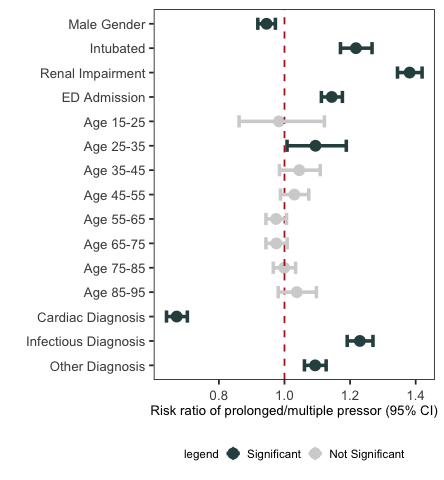

In [258]:
options(repr.plot.width=3.7, repr.plot.height=4)
p <- calculatePredictors(output_df)  %>%
    rowwise() %>%
    mutate(ID = ID_DICT[ID]) %>% 
    mutate(ID = factor(ID, levels=rev(ID_DICT))) %>%
    mutate(significant = if(significant){'Significant'}else{'Not Significant'}) %>%
    mutate(legend = factor(significant, levels=names(SIGNIFICANT_COLORS))) %>%
    ggplot(aes(x = ID,y = estimate, ymin = lower, ymax = upper ))+
        base_theme() +
        theme(legend.position="bottom")+
        geom_pointrange(aes(col=legend))+
        scale_color_manual(values=SIGNIFICANT_COLORS)+
        geom_hline(yintercept =1, linetype=2, color = "firebrick")+
        xlab('')+ ylab("Risk ratio of prolonged/multiple pressor (95% CI)")+
        geom_errorbar(aes(ymin=lower, ymax=upper,col=significant),width=0.5,cex=1)+ 
        coord_flip()
plot(p)

In [259]:
pdf(file.path(PLOT_DIR, "relativerisk.pdf"), 3.7,4)
plot(p)
dev.off()

pdf 
  2

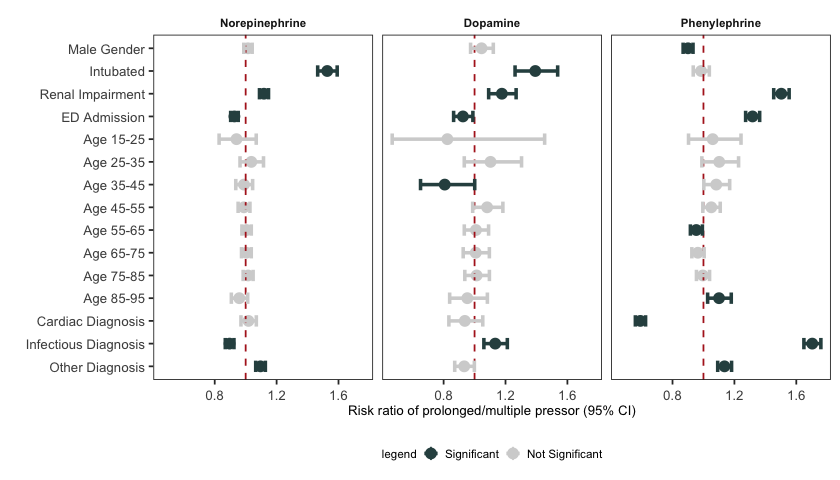

In [260]:
options(repr.plot.width=7, repr.plot.height=4)
p <- pressor_rr_df  %>%
    rowwise() %>%
    mutate(ID = ID_DICT[ID]) %>% 
    mutate(ID = factor(ID, levels=rev(ID_DICT))) %>%
    mutate(significant = if(significant){'Significant'}else{'Not Significant'}) %>%
    mutate(legend = factor(significant, levels=names(SIGNIFICANT_COLORS))) %>%
    mutate(fancy_pressor = FANCY_PRESSOR_DICT[as.character(pressor)]) %>%
    mutate(fancy_pressor = factor(fancy_pressor, levels=FANCY_PRESSOR_ORDER)) %>%
    ggplot(aes(x = ID,y = estimate, ymin = lower, ymax = upper ))+
        base_theme() +
        theme(legend.position="bottom")+
        geom_pointrange(aes(col=legend))+
        scale_color_manual(values=SIGNIFICANT_COLORS)+
        geom_hline(yintercept =1, linetype=2, color = "firebrick")+
        xlab('')+ ylab("Risk ratio of prolonged/multiple pressor (95% CI)")+
        geom_errorbar(aes(ymin=lower, ymax=upper,col=significant),width=0.5,cex=1)+ 
        coord_flip() + 
        facet_grid(. ~fancy_pressor)
plot(p)

In [261]:
pdf(file.path(PLOT_DIR, "relativerisk_eachpressor.pdf"), 7,4)
plot(p)
dev.off()

pdf 
  2

# Vitals

In [19]:
vitals_df <- read_csv(file.path(base_dir, 'vitals.csv.gz'))


── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────
cols(
  subject_id = col_double(),
  hadm_id = col_double(),
  stay_id = col_double(),
  charttime = col_datetime(format = ""),
  valuenum = col_double(),
  valueuom = col_character(),
  itemid = col_double(),
  assignment = col_character()
)




In [225]:
# 20  (1am), 3 hrs
vitals_merged_df <- vitals_df %>%
    filter(stay_id %in% output_df$stay_id) %>%
    left_join(dplyr::select(output_df, stay_id, course_id, pressor, intime, starttime, endtime, MORETHAN24HOURS, RESPONSE, STATUS), by = "stay_id") %>%
    mutate(charttime = fastPOSIXct(charttime), 
           starttime = fastPOSIXct(starttime), 
           intime = fastPOSIXct(intime)
          ) %>%
    mutate(
          start_pressortime = difftime(charttime, 
                       starttime, units="hours"),
          start_intime = difftime(charttime, 
                       intime, units="hours")) 

In [226]:
unique(vitals_merged_df$assignment)

[1] "HR"    "SBP"   "DBP"   "MBP"   "RR"    "SPO2"  "TEMPC" "TEMPF"

In [227]:
vitals_subset_df <- vitals_merged_df %>% 
    mutate(start_intime = as.numeric(start_intime)) %>%
    filter(assignment == "HR")  %>% 
    filter(charttime < starttime) 

In [228]:
survival_df <- output_df %>%
    filter(course_id %in% unique(vitals_subset_df$course_id)) %>%
    mutate(intime = fastPOSIXct(intime)) %>%
    mutate(start_intime = difftime(starttime, 
                       intime, units="hours")) %>% 
    mutate(start_intime = as.numeric(start_intime)) %>%
    mutate(dummy = 0)

In [229]:
# bug in JM, so arrange is needed
ctrl <- lmeControl(opt='optim');
lmeFit.p1 <- lme(valuenum ~ start_intime, random = ~ start_intime | course_id,
                 data = vitals_subset_df %>% 
                 arrange(course_id, start_intime),control=ctrl)

Warning message in logLik.lmeStructInt(lmeSt, lmePars):
“Singular precision matrix in level -1, block 544”
Warning message in logLik.lmeStructInt(lmeSt, lmePars):
“Singular precision matrix in level -1, block 544”
Warning message in logLik.lmeStructInt(lmeSt, lmePars):
“Singular precision matrix in level -1, block 544”
Warning message in logLik.lmeStructInt(lmeSt, lmePars):
“Singular precision matrix in level -1, block 544”
Warning message in logLik.lmeStructInt(lmeSt, lmePars):
“Singular precision matrix in level -1, block 544”
Warning message in logLik.lmeStructInt(lmeSt, lmePars):
“Singular precision matrix in level -1, block 544”
Warning message in logLik.lmeStructInt(lmeSt, lmePars):
“Singular precision matrix in level -1, block 544”
Warning message in logLik.lmeStructInt(lmeSt, lmePars):
“Singular precision matrix in level -1, block 544”
Warning message in logLik.lmeStructInt(lmeSt, lmePars):
“Singular precision matrix in level -1, block 544”
Warning message in logLik.lmeStructIn

In [230]:
summary(lmeFit.p1)

Linear mixed-effects model fit by REML
 Data: vitals_subset_df %>% arrange(course_id, start_intime) 
       AIC      BIC    logLik
  593290.5 593344.8 -296639.3

Random effects:
 Formula: ~start_intime | course_id
 Structure: General positive-definite, Log-Cholesky parametrization
             StdDev    Corr  
(Intercept)  16.868943 (Intr)
start_intime  1.916377 -0.42 
Residual     27.018133       

Fixed effects: valuenum ~ start_intime 
                Value Std.Error    DF  t-value p-value
(Intercept)  89.46024 0.4488110 59485 199.3272  0.0000
start_intime -0.09772 0.0737908 59485  -1.3243  0.1854
 Correlation: 
             (Intr)
start_intime -0.485

Standardized Within-Group Residuals:
         Min           Q1          Med           Q3          Max 
-20.35144164  -0.26339769  -0.03795255   0.21277393 210.93646997 

Number of Observations: 62307
Number of Groups: 2821 

In [231]:
survFit.p1 <- coxph(Surv(start_intime, RESPONSE) ~ 1, x = TRUE,
                    data = survival_df %>% arrange(course_id, start_intime)
                    )  

In [232]:
jointFit.p1 <- jointModel(lmeFit.p1, survFit.p1, timeVar = "start_intime",
    method = "Cox-PH-GH")

In [ ]:
dim(vitals_subset_df)

In [ ]:
confint(jointFit.p1)

### 1 hour based vitals smoothing

In [1]:
# for 10 hours prior to pressor initiation
intervals <- 1:10

In [484]:
results_list <- list()

In [485]:
# takes 40 mins to run overall
for(interval in intervals){
    # 4 mins to run each
    results_list[[interval]] <- vitals_merged_df %>%
        filter(diff < 0) %>%
        filter(diff < -(interval - 1) & diff > -interval) %>%
        group_by(MORETHAN24HOURS, RESPONSE, STATUS, course_id, pressor, assignment) %>%
        summarize(mean = mean(valuenum, na.rm=T)) %>%
        mutate(INTERVAL = interval)

}

Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”

In [486]:
melt_results_df <- bind_rows(results_list) 

In [487]:
#melt_results_df %>% write.csv(file.path(base_dir, 'melt_summarized_vitals_mimic4.csv'))

In [17]:
melt_results_df <- read.csv(file.path(base_dir, 'melt_summarized_vitals_mimic4.csv'))

### LMER model for vitals

In [244]:
melt_results_df <- melt_results_df %>%
    mutate(ID = assignment, VALUE = mean)

In [497]:
computeRandomEffects <- function(df){
    vitals_result_list <- list()
    for(vital in unique(df$ID)){
        #cat("####", vital, "####")
        totest <- df %>%
             filter(ID == vital)
        
        test <- lmer(VALUE ~ RESPONSE*INTERVAL + (1|course_id), data = totest) 
        ci <- confint(test, nsim=500)
        ce <- coef(summary(test))
        
        vitals_result_list[[vital]] <- data.frame(INTERACTION = ce['RESPONSETRUE:INTERVAL',][1],
            INTERACTION_LOWER = ci['RESPONSETRUE:INTERVAL',][1],
            INTERACTION_UPPER = ci['RESPONSETRUE:INTERVAL',][2],
            RESPONSE =  ce["RESPONSETRUE",][1],
            RESPONSE_LOWER = ci["RESPONSETRUE",][1],
            RESPONSE_UPPER = ci["RESPONSETRUE",][2])
        
    }
    vitals_result_df <- bind_rows(vitals_result_list, .id="ID")
    
    return(vitals_result_df)
    
}

In [498]:
randomeffects_significance_df  <- computeRandomEffects(melt_results_df)

Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
boundary (singular) fit: see ?isSingular
Computing profile confidence intervals ...
Computing profile confidence intervals ...


In [769]:
randomeffects_significance_df 

ID,INTERACTION,INTERACTION_LOWER,INTERACTION_UPPER,RESPONSE,RESPONSE_LOWER,RESPONSE_UPPER
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
DBP,3.30330079,-2.34489381,8.95160064,-8.25265712,-37.1502548,20.64491636
HR,0.02735677,-0.48613265,0.54042757,5.52932282,2.8679241,8.19097479
MBP,0.15061608,-0.32789340,0.62901893,-1.60824294,-4.1756920,0.95912319
RR,0.11031857,0.04267681,0.17788904,1.52419722,1.0807159,1.96765115
SBP,0.07095166,-0.17267007,0.31453853,-2.74026217,-4.2907113,-1.18962939
SPO2,-0.09302176,-0.22845596,0.04250286,-0.71040579,-1.4058888,-0.01505882
TEMPF,0.15588169,-0.21537883,0.52714227,-0.09405595,-1.9320625,1.74395058
TEMPC,-0.01089300,-0.07197409,0.05012774,0.27253285,-0.6416951,1.18674782


In [770]:
randomeffects_significance_df  %>% write.csv(file.path(PLOT_DIR, "re_significance.csv"))

In [503]:
pressors_vitals_rr_list <- list()
for(pressor_choice in c("Norepinephrine", "Dopamine", "Phenylephrine")){
    pressors_vitals_rr_list[[pressor_choice]] <- melt_results_df %>%
        filter(grepl(pressor_choice, pressor)) %>%
        computeRandomEffects()
}

pressors_vitals_randomeffects_df <- bind_rows(pressors_vitals_rr_list, .id="pressor")

Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
boundary (singular) fit: see ?isSingular
Computing profile confidence intervals ...
Warning message in zeta(shiftpar, start = opt[seqpar1][-w]):
“slightly lower deviances (diff=-3.63798e-12) detected”Warning message in nextpar(mat, cc, i, delta, lowcut, upcut):
“Last two rows have identical or NA .zeta values: using minstep”Warning message in zetafun(np, ns):
“slightly lower deviances (diff=-3.63798e-12) detected”Warning message in nextpar(mat, cc, i, delta, lowcut, upcut):
“Last two rows have identical or NA .zeta values: using minstep”Warning message in zetafun(np, ns):
“slightly lower deviances (diff=-3.63798e-12) detected”Warning message in nextpar(mat, cc, i, delta, lowcut, upcut):
“Last two rows have identical or NA .zeta valu

In [505]:
pressors_vitals_randomeffects_df %>% arrange(ID) 

pressor,ID,INTERACTION,INTERACTION_LOWER,INTERACTION_UPPER,RESPONSE,RESPONSE_LOWER,RESPONSE_UPPER
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Norepinephrine,DBP,5.930666024,-5.28585112,17.147425263,-15.62153491,-73.5363664,42.2936936
Dopamine,DBP,0.878801794,-0.24119652,1.982601257,2.56315714,-5.3655140,10.5008808
Phenylephrine,DBP,-1.540223771,-2.99762813,-0.082610821,3.72694176,-3.6684159,11.1216966
Norepinephrine,HR,-0.217467780,-0.45074364,0.015792150,6.67670739,4.2794864,9.0739117
Dopamine,HR,-0.130423113,-1.03936106,0.776691628,14.34528538,2.0646959,26.6239531
Phenylephrine,HR,-0.248136823,-1.02939637,0.531934234,7.45543207,3.4975291,11.4144738
Norepinephrine,MBP,0.122558457,-0.79884421,1.043616697,-0.69387418,-5.6766781,4.2897733
Dopamine,MBP,0.635187170,-0.57694909,1.826983768,2.92783332,-5.5905785,11.4561202
Phenylephrine,MBP,0.044037477,-0.20259568,0.290664228,-1.94214317,-3.4495064,-0.4344073


In [771]:
pressors_vitals_randomeffects_df %>% write.csv(file.path(PLOT_DIR, "re_significance_eachpressor.csv"))

### Plotting vitals

In [245]:
toplot <- melt_results_df %>%
    mutate(INTERVAL = -INTERVAL) %>%
    drop_na(VALUE) %>%
    filter(ID != "DBP", ID != "SBP", ID != 'TEMPF')

In [246]:
# 3-5 mins
toplot <- toplot %>%
    rowwise() %>%
    mutate(ID = as.character(ID)) %>%
    mutate(FANCY_VITAL = FANCY_VITAL_DICT[ID]) %>%
    mutate(FANCY_VITAL = factor(FANCY_VITAL, levels=FANCY_VITAL_ORDER)) %>%
    mutate(FANCY_RESPONSE = if(RESPONSE){"Prolonged or multiple vasopressor"}else{"No prolonged or multiple vasopressor"})

`geom_smooth()` using formula 'y ~ x'



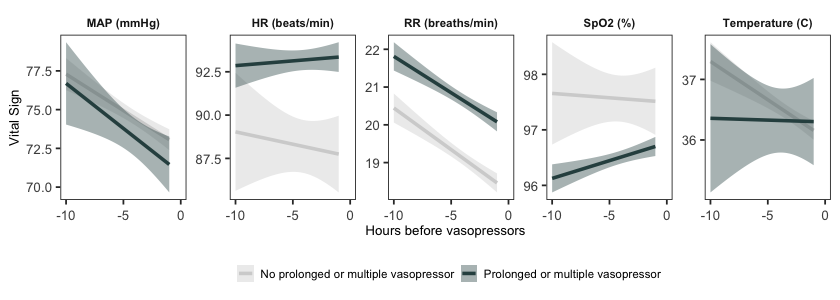

In [247]:
options(repr.plot.width=7, repr.plot.height=2.5)

p <- toplot %>%
    ggplot(aes(x=INTERVAL, y=VALUE, color=FANCY_RESPONSE)) +
        geom_smooth(method=lm, aes(fill=FANCY_RESPONSE)) + 
        xlab("Hours before vasopressors") + ylab("Vital Sign") +
        scale_x_continuous(limits=c(-10,0), breaks=seq(-10,0,5)) +
        base_theme() + 
        scale_color_manual(values=PRESSORHOURS_COLORS)+
        scale_fill_manual(values=PRESSORHOURS_COLORS)+
        theme(legend.title = element_blank()) +
        theme(legend.position="bottom") +
        facet_wrap(. ~ FANCY_VITAL, scale="free", nrow=1)
plot(p)

In [248]:
pdf(file.path(PLOT_DIR, "ancova_vitals.pdf"), 7,2.5)
plot(p)
dev.off()

`geom_smooth()` using formula 'y ~ x'



pdf 
  2

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

Warning message in qt((1 - level)/2, df):
“NaNs produced”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
`geom_smooth()` using formula 'y ~ x'

Warning message in qt((1 - level)/2, df):
“NaNs produced”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”


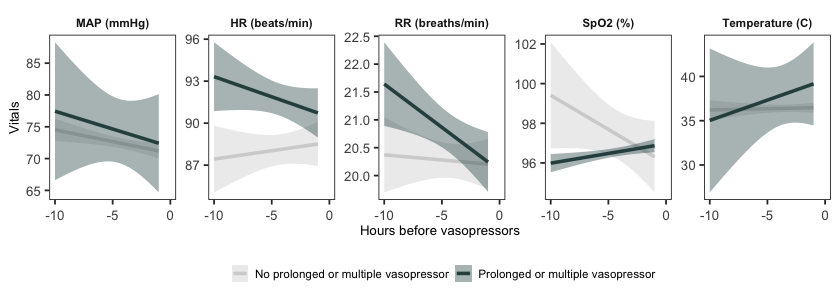

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



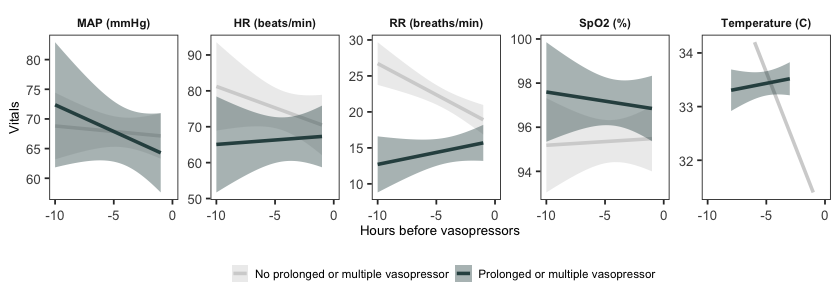

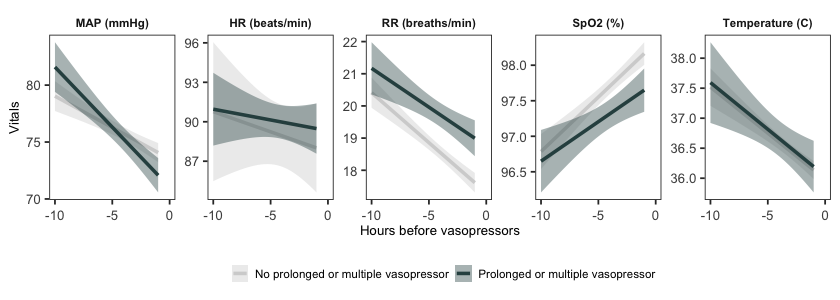

In [249]:
options(repr.plot.width=7, repr.plot.height=2.5)
for(pressor_choice in c("Norepinephrine", "Dopamine", "Phenylephrine")){
    toplot <- melt_results_df %>%
        filter(!grepl(",", pressor)) %>%
        mutate(INTERVAL = -INTERVAL) %>%
        drop_na(VALUE) %>%
        filter(pressor == pressor_choice, ID != "DBP", ID != "SBP", ID != 'TEMPF') %>%
        rowwise() %>%
        mutate(ID = as.character(ID)) %>%
        mutate(FANCY_VITAL = FANCY_VITAL_DICT[ID]) %>%
        mutate(FANCY_VITAL = factor(FANCY_VITAL, levels=FANCY_VITAL_ORDER)) %>%
        mutate(FANCY_RESPONSE = if(RESPONSE){"Prolonged or multiple vasopressor"}else{"No prolonged or multiple vasopressor"})

    p <- ggplot(toplot, aes(x=INTERVAL, y=VALUE, color=FANCY_RESPONSE)) +
        geom_smooth(method=lm, aes(fill=FANCY_RESPONSE)) + 
        xlab("Hours before vasopressors") + ylab("Vitals") +
        scale_x_continuous(limits=c(-10,0), breaks=seq(-10,0,5)) +
        base_theme() + 
        scale_color_manual(values=PRESSORHOURS_COLORS)+
        scale_fill_manual(values=PRESSORHOURS_COLORS)+
        theme(legend.title = element_blank()) +
        theme(legend.position="bottom") +
        facet_wrap(. ~ FANCY_VITAL, scale="free", nrow=1)
    
#     if(pressor_choice == 'phenylephrinedurations'){
#         p <- p + theme(legend.position="bottom")
#     }
    
    plot(p)
    
    pdf(file.path(PLOT_DIR, paste0(pressor_choice, "_ancova_vitals.pdf")), 7,2.5)
    plot(p)
    dev.off()
}

# MLR analysis

In [54]:
set.seed(100)

In [55]:
lr_summary_list <- list()

## Total

In [19]:
model_input_df <- melt_results_df %>%
    filter(INTERVAL == 1) %>%
    dplyr::select(-pressor) %>%
    ungroup() %>%
    mutate(VARIABLE = assignment, COURSE = course_id, VALUE = mean) %>%
    #mutate(VARIABLE = paste(ID, INTERVAL, sep = '_'), COURSE = course_id) %>%
    dplyr::select(RESPONSE, COURSE, VARIABLE, VALUE) %>%
    mutate(VALUE = as.character(VALUE)) %>%
    bind_rows(
        output_df %>% 
            mutate(pressor_choice = grepl('Norepinephrine', pressor)) %>%
            dplyr::select(-pressor) %>%
            dplyr::select(RESPONSE, course_id, first_careunit, cvc, intub, simple_diagnosis, gender, age_cohort, ed_admission, creatinine, pressor_choice) %>%
            gather(VARIABLE, VALUE, -RESPONSE, -course_id) %>%
            rename(COURSE = course_id) %>%
            distinct(COURSE, VARIABLE, VALUE, .keep_all = TRUE)
    ) %>%
    drop_na(VALUE) %>%
    spread(VARIABLE, VALUE) %>% 
    dplyr::select(-COURSE) %>%
    rowwise() %>%
    mutate(age_cohort = as.numeric(age_cohort)) %>%
    dplyr::select(RESPONSE,
             first_careunit,
             intub,
             simple_diagnosis,
             age_cohort,
             gender,
             creatinine,
             ed_admission,
             pressor_choice,
             contains("MBP"),
             contains("RR"),
             contains("HR") ,
             #contains("TEMPC"),
             contains("SPO2")
              ) %>%
    mutate(MBP = as.numeric(MBP), 
           RR = as.numeric(RR), 
           HR = as.numeric(HR),
           #age_cohort = as.numeric(age_cohort),
           SPO2 = as.numeric(SPO2))

# exclude missing cases (done automatically by glm but this allows some more fine control)
model_input_cleaned_df <- model_input_df[which(complete.cases(model_input_df)),]

In [20]:
base_model <- glm(RESPONSE ~ . , family=binomial(link='logit'),
        data=model_input_cleaned_df)

base_model %>% saveRDS(file.path(APP_DIR, 'model.rds'))

In [104]:
options(repr.plot.width=3, repr.plot.height=3)
input <- model_input_cleaned_df
k <- 5
n <- dim(input)[1]
indices <- sample(rep(1:k, ceiling(n/k))[1:n])


all.acc <- all.response <- all.predictor <- aucs <- c()
for (i in 1:k) {
  test = input[indices==i,]
  learn = input[indices!=i,]
  model <- glm(RESPONSE ~ . , family=binomial(link='logit'),data=learn)
  model.pred <- predict(model, newdata=test)
  model.acc <- data.frame(PRED = model.pred > 0, RESPONSE = test$RESPONSE) %>% 
        summarize(ACC = sum(PRED == RESPONSE)/n()) %>% unlist()
  aucs <- c(aucs, roc(test$RESPONSE, model.pred)$auc)
  all.response <- c(all.response, test$RESPONSE)
  all.predictor <- c(all.predictor, model.pred)
  all.acc <- c(all.acc, model.acc)
}
car::vif(model) %>% print()
p_out <- roc(all.response, all.predictor, grid=T, legacy.axes=T, ci=TRUE, auc=T)
#plot(p_out, print.auc=TRUE)

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases



                     GVIF Df GVIF^(1/(2*Df))
first_careunit   2.733241  5        1.105778
intub            1.248427  1        1.117330
simple_diagnosis 1.810080  2        1.159910
age_cohort       1.075428  1        1.037029
gender           1.049548  1        1.024475
creatinine       1.114053  1        1.055487
ed_admission     1.251163  1        1.118554
pressor_choice   1.496054  1        1.223133
MBP              1.025053  1        1.012449
RR               1.255747  1        1.120601
HR               1.181930  1        1.087166
SPO2             1.136712  1        1.066167


Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases



In [105]:
lr_summary_list[['TOTAL']] <- data.frame(MEAN_AUC = mean(aucs), 
                                         SD_AUC = sd(aucs), 
                                         MEAN_ACC = mean(all.acc), 
                                         SD_ACC = sd(all.acc))
lr_summary_list[['TOTAL']] 

MEAN_AUC,SD_AUC,MEAN_ACC,SD_ACC
<dbl>,<dbl>,<dbl>,<dbl>
0.7471593,0.01313665,0.690795,0.01159154


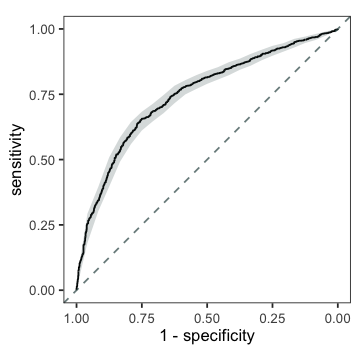

In [106]:
options(repr.plot.width=3, repr.plot.height=3)
p <- roc_with_ci(p_out) + xlab("1 - specificity")

plot(p)

In [107]:
pdf(file.path(PLOT_DIR, paste0("modelauc.pdf")), 3,3)
plot(p)
dev.off()

pdf 
  2

In [67]:
# imputation: 30 mins
model_input_imputed_df <- 
    rfImpute(RESPONSE ~ . , family=binomial(link='logit'), data=model_input_df %>% 
             dplyr::select(MBP, HR, RR, SPO2, RESPONSE)) %>%
    cbind(model_input_df %>% dplyr::select(-MBP, 
                                           -HR, -RR, -SPO2, -RESPONSE))

Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”


     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2488    99.97 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”


     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2573   103.40 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”


     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2544   102.24 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”


     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2589   104.03 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”


     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2579   103.62 |


In [68]:
model_input_imputed_df$first_careunit <- factor(model_input_imputed_df$first_careunit)
model_input_imputed_df$simple_diagnosis <- factor(model_input_imputed_df$simple_diagnosis)

model_input_imputed_df$first_careunit <- relevel(model_input_imputed_df$first_careunit, ref = 'Surgical Intensive Care Unit (SICU)')
model_input_imputed_df$simple_diagnosis <- relevel(model_input_imputed_df$simple_diagnosis, ref = "OTHER DIAGNOSIS")

In [71]:
model <- glm(RESPONSE ~ . , family=binomial(link='logit'),data=model_input_imputed_df)

In [72]:
oddsratio <- exp(cbind(coef(model), confint(model))) %>% data.frame() %>%
    tibble::rownames_to_column("factor") %>%
    filter(factor != "(Intercept)") %>%
    rename(estimate = V1, lower = X2.5.., upper = X97.5..) %>%
    rowwise() %>%
    mutate(significant = (lower > 1 & upper > 1) | (lower < 1 & upper < 1)) %>%
    mutate(legend = if(significant){'Significant'}else{'Not Significant'}) 

Waiting for profiling to be done...



In [86]:
odds_df <- odds_map %>%
    mutate_all(as.character) %>%
    rename(factor=FIELD) %>%
    left_join(oddsratio) %>%
    replace_na(list(estimate=1, lower=1, upper=1, legend="Reference"))

Joining, by = "factor"



In [87]:
odds_df %>%
    filter(CLASS == "Categorical") %>%
    write.csv(file.path(PLOT_DIR, paste0("categoricalmodeleodds.csv")))

In [88]:
read.csv(file.path(PLOT_DIR, paste0("categoricalmodeleodds.csv")))

X,CLASS,TYPE,factor,REFERENCE,FORMAL,estimate,lower,upper,significant,legend
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>,<chr>
1,Categorical,Careunit,first_careunitMedical Intensive Care Unit (MICU),Variable,MICU,0.7239508,0.6388012,0.8201151,TRUE,Significant
2,Categorical,Careunit,first_careunitMedical/Surgical Intensive Care Unit (MICU/SICU),Variable,MSICU,0.6469623,0.5648384,0.7408075,TRUE,Significant
3,Categorical,Careunit,first_careunitNeuro Surgical Intensive Care Unit (Neuro SICU),Variable,NSICU,0.8493211,0.6558652,1.1005374,FALSE,Not Significant
4,Categorical,Careunit,first_careunitSurgical Intensive Care Unit (SICU),Reference,SICU,1.0000000,1.0000000,1.0000000,NA,Reference
5,Categorical,Careunit,first_careunitTrauma SICU (TSICU),Variable,TSICU,1.0670145,0.9304848,1.2236553,FALSE,Not Significant
6,Categorical,Careunit,first_careunitCardiac Vascular Intensive Care Unit (CVICU),Variable,CVICU,0.9309952,0.8227572,1.0534981,FALSE,Not Significant
7,Categorical,Intubation,intubTRUE,Variable,Intubated,2.3610042,2.1595977,2.5819903,TRUE,Significant
8,Categorical,Intubation,,Reference,Not Intubated,1.0000000,1.0000000,1.0000000,NA,Reference
9,Categorical,GFR,creatinineTRUE,Variable,Impaired,1.6121358,1.4974278,1.7357922,TRUE,Significant


In [89]:
odds_df %>%
    filter(CLASS == "Continuous") %>%
    write.csv(file.path(PLOT_DIR, paste0("continuousmodeleodds.csv")))

In [90]:
read.csv(file.path(PLOT_DIR, paste0("continuousmodeleodds.csv")))

X,CLASS,TYPE,factor,REFERENCE,FORMAL,estimate,lower,upper,significant,legend
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>,<chr>
1,Continuous,Vitals,MBP,Variable,MAP,0.9975847,0.9941393,1.0010473,FALSE,Not Significant
2,Continuous,Vitals,HR,Variable,HR,1.0060435,1.0034155,1.0086857,TRUE,Significant
3,Continuous,Vitals,RR,Variable,RR,1.0059471,1.0013740,1.0105459,TRUE,Significant
4,Continuous,Vitals,SPO2,Variable,SpO2,0.9964626,0.9932343,0.9996958,TRUE,Significant
5,Continuous,Age,age_cohort,Variable,Age,1.0023614,1.0000548,1.0046734,TRUE,Significant


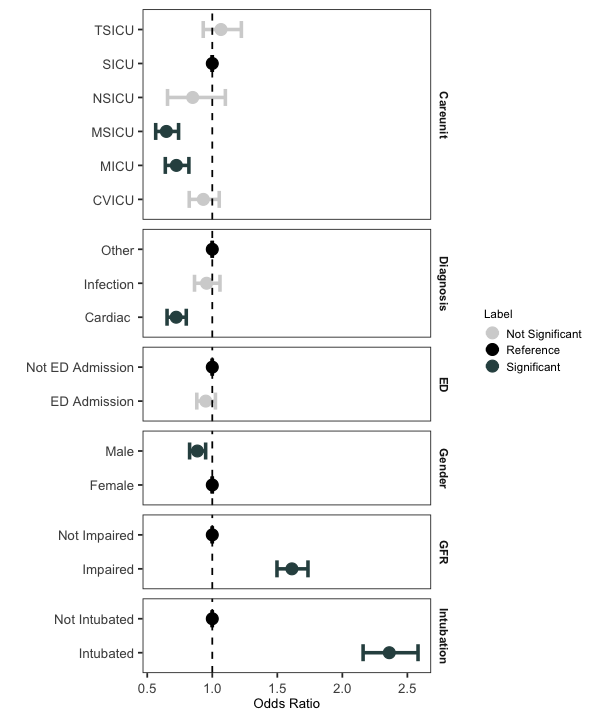

In [92]:
options(repr.plot.width=5, repr.plot.height=6)
.x <- NULL
p <- odds_df %>%
    filter(CLASS == "Categorical") %>%
    #mutate(FIELD = factor(FIELD, levels=FIELD_ORDER)) %>%
    ggplot(aes(x=FORMAL, ymin=upper, ymax=lower, color=legend)) +
    base_theme() +
    geom_errorbar(aes(ymin=lower, ymax=upper,col=legend),width=0.5,cex=1)+ 
    geom_point(aes(y=estimate), size=3) +
    ylab("Odds Ratio") +
    xlab("") +
    scale_color_manual(values=REF_COLORS, name="Label") + 
    #scale_y_log10(limits=NULL, breaks=1:10) +
                          #breaks=scales::trans_breaks("log10", function(x) 10^x),
                          #labels=scales::trans_format("log10", scales::math_format(10^.x))) +
    geom_hline(yintercept=1, linetype="dashed", color = "black") +
    facet_grid(rows=vars(TYPE), drop=F, scales="free_y", space="free_y") + coord_flip()
plot(p)

In [93]:
pdf(file.path(PLOT_DIR, paste0("categoricalmodelodds.pdf")), 5,6)
plot(p)
dev.off()

pdf 
  2

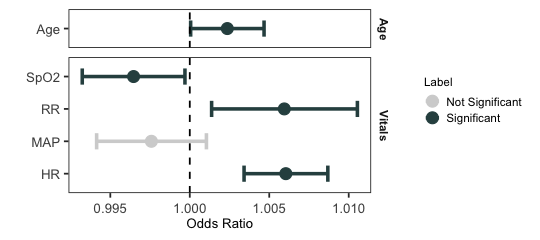

In [94]:
options(repr.plot.width=4.5, repr.plot.height=2)
.x <- NULL
p <- odds_df %>%
    filter(CLASS == "Continuous") %>%
    #mutate(FIELD = factor(FIELD, levels=FIELD_ORDER)) %>%
    ggplot(aes(x=FORMAL, ymin=upper, ymax=lower, color=legend)) +
    base_theme() +
    geom_errorbar(aes(ymin=lower, ymax=upper,col=legend),width=0.5,cex=1)+ 
    geom_point(aes(y=estimate), size=3) +
    ylab("Odds Ratio") +
    xlab("") +
    scale_color_manual(values=REF_COLORS, name="Label") + 
    #scale_y_log10(limits=NULL, breaks=1:10) +
                          #breaks=scales::trans_breaks("log10", function(x) 10^x),
                          #labels=scales::trans_format("log10", scales::math_format(10^.x))) +
    geom_hline(yintercept=1, linetype="dashed", color = "black") +
    facet_grid(rows=vars(TYPE), drop=F, scales="free_y", space="free_y") + coord_flip()
plot(p)

In [95]:
pdf(file.path(PLOT_DIR, paste0("continuousmodelodds.pdf")), 4.5,2)
plot(p)
dev.off()

pdf 
  2

## Norepinephrine

In [250]:
pressor_choice <- 'Norepinephrine'

In [251]:
model_input_df <- melt_results_df %>%
    filter(INTERVAL == 1) %>%
    dplyr::select(-pressor) %>%
    ungroup() %>%
    mutate(VARIABLE = assignment, COURSE = course_id, VALUE = mean) %>%
    #mutate(VARIABLE = paste(ID, INTERVAL, sep = '_'), COURSE = course_id) %>%
    dplyr::select(RESPONSE, COURSE, VARIABLE, VALUE) %>%
    mutate(VALUE = as.character(VALUE)) %>%
    bind_rows(
        output_df %>% 
            filter(grepl(pressor_choice, pressor)) %>%
            dplyr::select(-pressor) %>%
            dplyr::select(RESPONSE, course_id, first_careunit, cvc, intub, simple_diagnosis, gender, age_cohort, ed_admission, creatinine) %>%
            gather(VARIABLE, VALUE, -RESPONSE, -course_id) %>%
            rename(COURSE = course_id) %>%
            distinct(COURSE, VARIABLE, VALUE, .keep_all = TRUE)
    ) %>%
    drop_na(VALUE) %>%
    spread(VARIABLE, VALUE) %>% 
    dplyr::select(-COURSE) %>%
    rowwise() %>%
    mutate(age_cohort = as.numeric(age_cohort)) %>%
    dplyr::select(RESPONSE,
             first_careunit,
             intub,
             simple_diagnosis,
             age_cohort,
             gender,
             creatinine,
             ed_admission,
             contains("MBP"),
             contains("RR"),
             contains("HR") ,
             #contains("TEMPC"),
             contains("SPO2")
              ) %>%
    mutate(MBP = as.numeric(MBP), 
           RR = as.numeric(RR), 
           HR = as.numeric(HR),
           #age_cohort = as.numeric(age_cohort),
           SPO2 = as.numeric(SPO2))



# exclude missing cases (done automatically by glm but this allows some more fine control)
model_input_cleaned_df <- model_input_df[which(complete.cases(model_input_df)),]

In [252]:
dim(model_input_cleaned_df)

[1] 1264   12

In [253]:
model_input_cleaned_df <- model_input_cleaned_df %>% sample_frac(fraction=1)

In [254]:
options(repr.plot.width=3, repr.plot.height=3)
input <- model_input_cleaned_df
k <- 5
n <- dim(input)[1]
indices <- sample(rep(1:k, ceiling(n/k))[1:n])


all.acc <- all.response <- all.predictor <- aucs <- c()
for (i in 1:k) {
  test = input[indices==i,]
  learn = input[indices!=i,]
  model <- glm(RESPONSE ~ . , family=binomial(link='logit'),data=learn)
  model.pred <- predict(model, newdata=test)
  model.acc <- data.frame(PRED = model.pred > 0, RESPONSE = test$RESPONSE) %>% 
        summarize(ACC = sum(PRED == RESPONSE)/n()) %>% unlist()
  aucs <- c(aucs, roc(test$RESPONSE, model.pred)$auc)
  all.response <- c(all.response, test$RESPONSE)
  all.predictor <- c(all.predictor, model.pred)
  all.acc <- c(all.acc, model.acc)
}
car::vif(model) %>% print()
p_out <- roc(all.response, all.predictor, grid=T, legacy.axes=T, ci=TRUE, auc=T)
#plot(p_out, print.auc=TRUE)

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases



                     GVIF Df GVIF^(1/(2*Df))
first_careunit   1.558985  5        1.045404
intub            1.131236  1        1.063596
simple_diagnosis 1.390704  2        1.085947
age_cohort       1.082143  1        1.040261
gender           1.026607  1        1.013216
creatinine       1.082428  1        1.040398
ed_admission     1.121234  1        1.058883
MBP              1.016911  1        1.008420
RR               1.181284  1        1.086869
HR               1.177584  1        1.085165
SPO2             1.059355  1        1.029250


Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases



In [255]:
lr_summary_list[[pressor_choice]] <- data.frame(MEAN_AUC = mean(aucs), 
                                         SD_AUC = sd(aucs), 
                                         MEAN_ACC = mean(all.acc), 
                                         SD_ACC = sd(all.acc))
lr_summary_list[[pressor_choice]] 

MEAN_AUC,SD_AUC,MEAN_ACC,SD_ACC
<dbl>,<dbl>,<dbl>,<dbl>
0.6918419,0.03643342,0.7293933,0.02988347


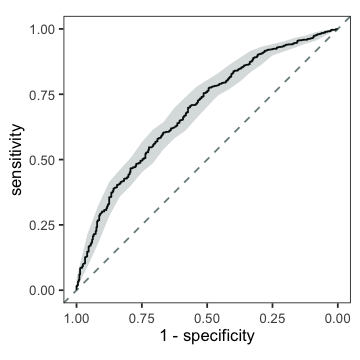

In [256]:
options(repr.plot.width=3, repr.plot.height=3)
p <- roc_with_ci(p_out) + xlab("1 - specificity")

plot(p)

In [257]:
pdf(file.path(PLOT_DIR, paste0(pressor_choice, "_modelauc.pdf")), 3,3)
plot(p)
dev.off()

pdf 
  2

In [258]:
# imputation: 30 mins
model_input_imputed_df <- 
    rfImpute(RESPONSE ~ . , family=binomial(link='logit'), data=model_input_df %>% dplyr::select(MBP, HR, RR, SPO2, RESPONSE)) %>%
    cbind(model_input_df %>% dplyr::select(-MBP, -HR, -RR, -SPO2, -RESPONSE))

Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”


     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2182    97.55 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”


     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2261   101.07 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”


     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2249   100.56 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”


     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2305   103.07 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”


     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2282   102.03 |


In [259]:
model_input_imputed_df$first_careunit <- factor(model_input_imputed_df$first_careunit)
model_input_imputed_df$simple_diagnosis <- factor(model_input_imputed_df$simple_diagnosis)

model_input_imputed_df$first_careunit <- relevel(model_input_imputed_df$first_careunit, ref = 'Surgical Intensive Care Unit (SICU)')
model_input_imputed_df$simple_diagnosis <- relevel(model_input_imputed_df$simple_diagnosis, ref = "OTHER DIAGNOSIS")

In [260]:
model <- glm(RESPONSE ~ . , family=binomial(link='logit'),data=model_input_imputed_df)

In [261]:
oddsratio <- exp(cbind(coef(model), confint(model))) %>% data.frame() %>%
    tibble::rownames_to_column("factor") %>%
    filter(factor != "(Intercept)") %>%
    rename(estimate = V1, lower = X2.5.., upper = X97.5..) %>%
    rowwise() %>%
    mutate(significant = (lower > 1 & upper > 1) | (lower < 1 & upper < 1)) %>%
    mutate(legend = if(significant){'Significant'}else{'Not Significant'}) 

Waiting for profiling to be done...



In [262]:
odds_df <- odds_map %>%
    mutate_all(as.character) %>%
    rename(factor=FIELD) %>%
    left_join(oddsratio) %>%
    replace_na(list(estimate=1, lower=1, upper=1, legend="Reference"))

Joining, by = "factor"



In [263]:
odds_df %>%
    filter(CLASS == "Categorical") %>%
    write.csv(file.path(PLOT_DIR, paste0(pressor_choice, "_categoricalmodeleodds.csv")))

In [264]:
read.csv(file.path(PLOT_DIR, paste0(pressor_choice, "_categoricalmodeleodds.csv")))

X,CLASS,TYPE,factor,REFERENCE,FORMAL,estimate,lower,upper,significant,legend
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>,<chr>
1,Categorical,Careunit,first_careunitMedical Intensive Care Unit (MICU),Variable,MICU,0.7142878,0.6072353,0.8384781,TRUE,Significant
2,Categorical,Careunit,first_careunitMedical/Surgical Intensive Care Unit (MICU/SICU),Variable,MSICU,0.6735434,0.5662366,0.7999333,TRUE,Significant
3,Categorical,Careunit,first_careunitNeuro Surgical Intensive Care Unit (Neuro SICU),Variable,NSICU,0.7960318,0.5571146,1.1501114,FALSE,Not Significant
4,Categorical,Careunit,first_careunitSurgical Intensive Care Unit (SICU),Reference,SICU,1.0000000,1.0000000,1.0000000,NA,Reference
5,Categorical,Careunit,first_careunitTrauma SICU (TSICU),Variable,TSICU,1.0852847,0.8860185,1.3299680,FALSE,Not Significant
6,Categorical,Careunit,first_careunitCardiac Vascular Intensive Care Unit (CVICU),Variable,CVICU,1.0147196,0.8288950,1.2420261,FALSE,Not Significant
7,Categorical,Intubation,intubTRUE,Variable,Intubated,3.2683836,2.9396427,3.6349814,TRUE,Significant
8,Categorical,Intubation,,Reference,Not Intubated,1.0000000,1.0000000,1.0000000,NA,Reference
9,Categorical,GFR,creatinineTRUE,Variable,Impaired,1.7156541,1.5555449,1.8930996,TRUE,Significant


In [265]:
odds_df %>%
    filter(CLASS == "Continuous") %>%
    write.csv(file.path(PLOT_DIR, paste0(pressor_choice, "_continuousmodeleodds.csv")))

In [266]:
read.csv(file.path(PLOT_DIR, paste0(pressor_choice, "_continuousmodeleodds.csv")))

X,CLASS,TYPE,factor,REFERENCE,FORMAL,estimate,lower,upper,significant,legend
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>,<chr>
1,Continuous,Vitals,MBP,Variable,MAP,1.000234,0.9954706,1.0050788,FALSE,Not Significant
2,Continuous,Vitals,HR,Variable,HR,1.004204,1.0008739,1.0075531,TRUE,Significant
3,Continuous,Vitals,RR,Variable,RR,1.005775,0.9980259,1.0135914,FALSE,Not Significant
4,Continuous,Vitals,SPO2,Variable,SpO2,0.993967,0.9881038,0.9997526,TRUE,Significant
5,Continuous,Age,age_cohort,Variable,Age,1.001362,0.9982407,1.0044857,FALSE,Not Significant


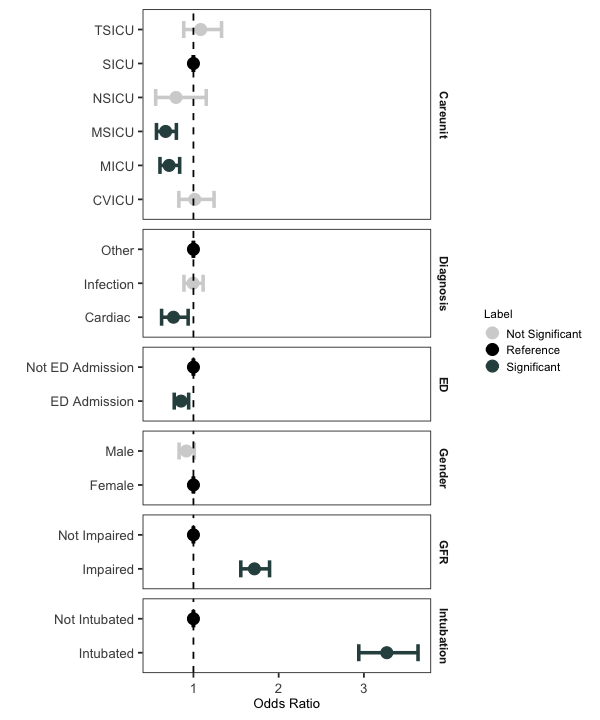

In [267]:
options(repr.plot.width=5, repr.plot.height=6)
.x <- NULL
p <- odds_df %>%
    filter(CLASS == "Categorical") %>%
    #mutate(FIELD = factor(FIELD, levels=FIELD_ORDER)) %>%
    ggplot(aes(x=FORMAL, ymin=upper, ymax=lower, color=legend)) +
    base_theme() +
    geom_errorbar(aes(ymin=lower, ymax=upper,col=legend),width=0.5,cex=1)+ 
    geom_point(aes(y=estimate), size=3) +
    ylab("Odds Ratio") +
    xlab("") +
    scale_color_manual(values=REF_COLORS, name="Label") + 
    #scale_y_log10(limits=NULL, breaks=1:10) +
                          #breaks=scales::trans_breaks("log10", function(x) 10^x),
                          #labels=scales::trans_format("log10", scales::math_format(10^.x))) +
    geom_hline(yintercept=1, linetype="dashed", color = "black") +
    facet_grid(rows=vars(TYPE), drop=F, scales="free_y", space="free_y") + coord_flip()
plot(p)

In [268]:
pdf(file.path(PLOT_DIR, paste0(pressor_choice, "_categoricalmodelodds.pdf")), 5,6)
plot(p)
dev.off()

pdf 
  2

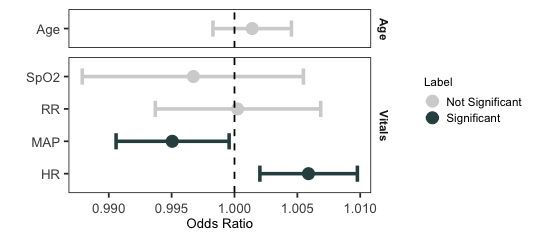

In [128]:
options(repr.plot.width=4.5, repr.plot.height=2)
.x <- NULL
p <- odds_df %>%
    filter(CLASS == "Continuous") %>%
    #mutate(FIELD = factor(FIELD, levels=FIELD_ORDER)) %>%
    ggplot(aes(x=FORMAL, ymin=upper, ymax=lower, color=legend)) +
    base_theme() +
    geom_errorbar(aes(ymin=lower, ymax=upper,col=legend),width=0.5,cex=1)+ 
    geom_point(aes(y=estimate), size=3) +
    ylab("Odds Ratio") +
    xlab("") +
    scale_color_manual(values=REF_COLORS, name="Label") + 
    #scale_y_log10(limits=NULL, breaks=1:10) +
                          #breaks=scales::trans_breaks("log10", function(x) 10^x),
                          #labels=scales::trans_format("log10", scales::math_format(10^.x))) +
    geom_hline(yintercept=1, linetype="dashed", color = "black") +
    facet_grid(rows=vars(TYPE), drop=F, scales="free_y", space="free_y") + coord_flip()
plot(p)

In [129]:
pdf(file.path(PLOT_DIR, paste0(pressor_choice, "_continuousmodelodds.pdf")), 4.5,2)
plot(p)
dev.off()

pdf 
  2

## Phenylephrine

In [130]:
pressor_choice <- 'Phenylephrine'

In [132]:
model_input_df <- melt_results_df %>%
    filter(INTERVAL == 1) %>%
    dplyr::select(-pressor) %>%
    ungroup() %>%
    mutate(VARIABLE = assignment, COURSE = course_id, VALUE = mean) %>%
    #mutate(VARIABLE = paste(ID, INTERVAL, sep = '_'), COURSE = course_id) %>%
    dplyr::select(RESPONSE, COURSE, VARIABLE, VALUE) %>%
    mutate(VALUE = as.character(VALUE)) %>%
    bind_rows(
        output_df %>% 
            filter(grepl(pressor_choice, pressor)) %>%
            dplyr::select(-pressor) %>%
            dplyr::select(RESPONSE, course_id, first_careunit, cvc, intub, simple_diagnosis, gender, age_cohort, ed_admission, creatinine) %>%
            gather(VARIABLE, VALUE, -RESPONSE, -course_id) %>%
            rename(COURSE = course_id) %>%
            distinct(COURSE, VARIABLE, VALUE, .keep_all = TRUE)
    ) %>%
    drop_na(VALUE) %>%
    spread(VARIABLE, VALUE) %>% 
    dplyr::select(-COURSE) %>%
    rowwise() %>%
    mutate(age_cohort = as.numeric(age_cohort)) %>%
    dplyr::select(RESPONSE,
             first_careunit,
             intub,
             simple_diagnosis,
             age_cohort,
             gender,
             creatinine,
             ed_admission,
             contains("MBP"),
             contains("RR"),
             contains("HR") ,
             #contains("TEMPC"),
             contains("SPO2")
              ) %>%
    mutate(MBP = as.numeric(MBP), 
           RR = as.numeric(RR), 
           HR = as.numeric(HR),
           #age_cohort = as.numeric(age_cohort),
           SPO2 = as.numeric(SPO2))



# exclude missing cases (done automatically by glm but this allows some more fine control)
model_input_cleaned_df <- model_input_df[which(complete.cases(model_input_df)),]

In [133]:
dim(model_input_cleaned_df)

[1] 1530   12

In [134]:
model_input_cleaned_df <- model_input_cleaned_df %>% sample_frac(fraction=1)

In [135]:
options(repr.plot.width=3, repr.plot.height=3)
input <- model_input_cleaned_df
k <- 5
n <- dim(input)[1]
indices <- sample(rep(1:k, ceiling(n/k))[1:n])


all.acc <- all.response <- all.predictor <- aucs <- c()
for (i in 1:k) {
  test = input[indices==i,]
  learn = input[indices!=i,]
  model <- glm(RESPONSE ~ . , family=binomial(link='logit'),data=learn)
  model.pred <- predict(model, newdata=test)
  model.acc <- data.frame(PRED = model.pred > 0, RESPONSE = test$RESPONSE) %>% 
        summarize(ACC = sum(PRED == RESPONSE)/n()) %>% unlist()
  aucs <- c(aucs, roc(test$RESPONSE, model.pred)$auc)
  all.response <- c(all.response, test$RESPONSE)
  all.predictor <- c(all.predictor, model.pred)
  all.acc <- c(all.acc, model.acc)
}
car::vif(model) %>% print()
p_out <- roc(all.response, all.predictor, grid=T, legacy.axes=T, ci=TRUE, auc=T)
#plot(p_out, print.auc=TRUE)

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases



                     GVIF Df GVIF^(1/(2*Df))
first_careunit   2.411378  5        1.092010
intub            1.211570  1        1.100713
simple_diagnosis 1.682993  2        1.138992
age_cohort       1.074093  1        1.036385
gender           1.050085  1        1.024736
creatinine       1.096953  1        1.047355
ed_admission     1.293025  1        1.137113
MBP              1.034191  1        1.016952
RR               1.277333  1        1.130192
HR               1.312829  1        1.145788
SPO2             1.188738  1        1.090293


Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases



In [136]:
lr_summary_list[[pressor_choice]] <- data.frame(MEAN_AUC = mean(aucs), 
                                         SD_AUC = sd(aucs), 
                                         MEAN_ACC = mean(all.acc), 
                                         SD_ACC = sd(all.acc))
lr_summary_list[[pressor_choice]] 

MEAN_AUC,SD_AUC,MEAN_ACC,SD_ACC
<dbl>,<dbl>,<dbl>,<dbl>
0.709536,0.02901991,0.6614379,0.03018235


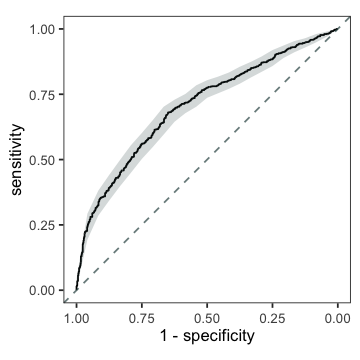

In [137]:
options(repr.plot.width=3, repr.plot.height=3)
p <- roc_with_ci(p_out) + xlab("1 - specificity")

plot(p)

In [138]:
pdf(file.path(PLOT_DIR, paste0(pressor_choice, "_modelauc.pdf")), 3,3)
plot(p)
dev.off()

pdf 
  2

In [141]:
# imputation: 30 mins
model_input_imputed_df <- 
    rfImpute(RESPONSE ~ . , family=binomial(link='logit'), data=model_input_df %>% dplyr::select(MBP, HR, RR, SPO2, RESPONSE)) %>%
    cbind(model_input_df %>% dplyr::select(-MBP, -HR, -RR, -SPO2, -RESPONSE))

Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”


     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2484    99.92 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”


     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2585   103.98 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”


     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2556   102.80 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”


     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2584   103.94 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”


     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2593   104.30 |


In [142]:
model_input_imputed_df$first_careunit <- factor(model_input_imputed_df$first_careunit)
model_input_imputed_df$simple_diagnosis <- factor(model_input_imputed_df$simple_diagnosis)

model_input_imputed_df$first_careunit <- relevel(model_input_imputed_df$first_careunit, ref = 'Surgical Intensive Care Unit (SICU)')
model_input_imputed_df$simple_diagnosis <- relevel(model_input_imputed_df$simple_diagnosis, ref = "OTHER DIAGNOSIS")

In [143]:
model <- glm(RESPONSE ~ . , family=binomial(link='logit'),data=model_input_imputed_df)

In [144]:
oddsratio <- exp(cbind(coef(model), confint(model))) %>% data.frame() %>%
    tibble::rownames_to_column("factor") %>%
    filter(factor != "(Intercept)") %>%
    rename(estimate = V1, lower = X2.5.., upper = X97.5..) %>%
    rowwise() %>%
    mutate(significant = (lower > 1 & upper > 1) | (lower < 1 & upper < 1)) %>%
    mutate(legend = if(significant){'Significant'}else{'Not Significant'}) 

Waiting for profiling to be done...



In [145]:
odds_df <- odds_map %>%
    mutate_all(as.character) %>%
    rename(factor=FIELD) %>%
    left_join(oddsratio) %>%
    replace_na(list(estimate=1, lower=1, upper=1, legend="Reference"))

Joining, by = "factor"



In [146]:
odds_df %>%
    filter(CLASS == "Categorical") %>%
    write.csv(file.path(PLOT_DIR, paste0(pressor_choice, "_categoricalmodeleodds.csv")))

In [147]:
read.csv(file.path(PLOT_DIR, paste0(pressor_choice, "_categoricalmodeleodds.csv")))

X,CLASS,TYPE,factor,REFERENCE,FORMAL,estimate,lower,upper,significant,legend
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>,<chr>
1,Categorical,Careunit,first_careunitMedical Intensive Care Unit (MICU),Variable,MICU,2.1004183,1.7618696,2.5082825,TRUE,Significant
2,Categorical,Careunit,first_careunitMedical/Surgical Intensive Care Unit (MICU/SICU),Variable,MSICU,1.4224260,1.1835875,1.7115225,TRUE,Significant
3,Categorical,Careunit,first_careunitNeuro Surgical Intensive Care Unit (Neuro SICU),Variable,NSICU,1.0502967,0.7924735,1.3947008,FALSE,Not Significant
4,Categorical,Careunit,first_careunitSurgical Intensive Care Unit (SICU),Reference,SICU,1.0000000,1.0000000,1.0000000,NA,Reference
5,Categorical,Careunit,first_careunitTrauma SICU (TSICU),Variable,TSICU,1.0906819,0.9387022,1.2674016,FALSE,Not Significant
6,Categorical,Careunit,first_careunitCardiac Vascular Intensive Care Unit (CVICU),Variable,CVICU,0.6883232,0.6003030,0.7889870,TRUE,Significant
7,Categorical,Intubation,intubTRUE,Variable,Intubated,1.7408474,1.5268686,1.9852742,TRUE,Significant
8,Categorical,Intubation,,Reference,Not Intubated,1.0000000,1.0000000,1.0000000,NA,Reference
9,Categorical,GFR,creatinineTRUE,Variable,Impaired,2.0748284,1.8845654,2.2852597,TRUE,Significant


In [148]:
odds_df %>%
    filter(CLASS == "Continuous") %>%
    write.csv(file.path(PLOT_DIR, paste0(pressor_choice, "_continuousmodeleodds.csv")))

In [149]:
read.csv(file.path(PLOT_DIR, paste0(pressor_choice, "_continuousmodeleodds.csv")))

X,CLASS,TYPE,factor,REFERENCE,FORMAL,estimate,lower,upper,significant,legend
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>,<chr>
1,Continuous,Vitals,MBP,Variable,MAP,0.9978941,0.9938675,1.001937,FALSE,Not Significant
2,Continuous,Vitals,HR,Variable,HR,1.0031334,0.9997971,1.006498,FALSE,Not Significant
3,Continuous,Vitals,RR,Variable,RR,1.0027346,0.9963511,1.009162,FALSE,Not Significant
4,Continuous,Vitals,SPO2,Variable,SpO2,0.9988820,0.9948852,1.002884,FALSE,Not Significant
5,Continuous,Age,age_cohort,Variable,Age,1.0000545,0.9971216,1.002993,FALSE,Not Significant


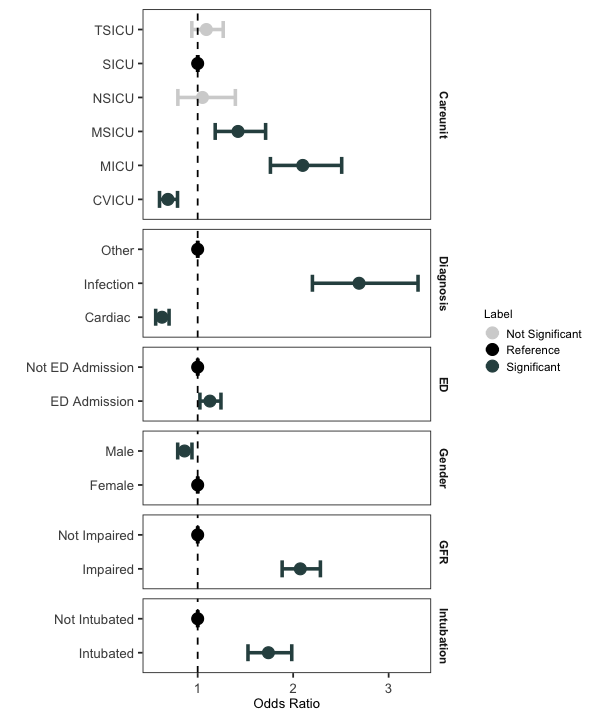

In [150]:
options(repr.plot.width=5, repr.plot.height=6)
.x <- NULL
p <- odds_df %>%
    filter(CLASS == "Categorical") %>%
    #mutate(FIELD = factor(FIELD, levels=FIELD_ORDER)) %>%
    ggplot(aes(x=FORMAL, ymin=upper, ymax=lower, color=legend)) +
    base_theme() +
    geom_errorbar(aes(ymin=lower, ymax=upper,col=legend),width=0.5,cex=1)+ 
    geom_point(aes(y=estimate), size=3) +
    ylab("Odds Ratio") +
    xlab("") +
    scale_color_manual(values=REF_COLORS, name="Label") + 
    #scale_y_log10(limits=NULL, breaks=1:10) +
                          #breaks=scales::trans_breaks("log10", function(x) 10^x),
                          #labels=scales::trans_format("log10", scales::math_format(10^.x))) +
    geom_hline(yintercept=1, linetype="dashed", color = "black") +
    facet_grid(rows=vars(TYPE), drop=F, scales="free_y", space="free_y") + coord_flip()
plot(p)

In [151]:
pdf(file.path(PLOT_DIR, paste0(pressor_choice, "_categoricalmodelodds.pdf")), 5,6)
plot(p)
dev.off()

pdf 
  2

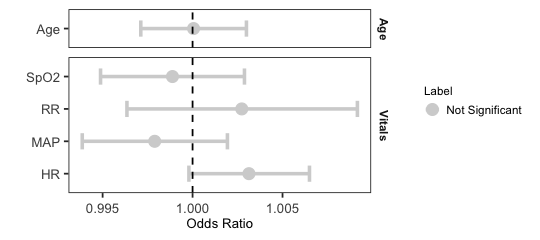

In [152]:
options(repr.plot.width=4.5, repr.plot.height=2)
.x <- NULL
p <- odds_df %>%
    filter(CLASS == "Continuous") %>%
    #mutate(FIELD = factor(FIELD, levels=FIELD_ORDER)) %>%
    ggplot(aes(x=FORMAL, ymin=upper, ymax=lower, color=legend)) +
    base_theme() +
    geom_errorbar(aes(ymin=lower, ymax=upper,col=legend),width=0.5,cex=1)+ 
    geom_point(aes(y=estimate), size=3) +
    ylab("Odds Ratio") +
    xlab("") +
    scale_color_manual(values=REF_COLORS, name="Label") + 
    #scale_y_log10(limits=NULL, breaks=1:10) +
                          #breaks=scales::trans_breaks("log10", function(x) 10^x),
                          #labels=scales::trans_format("log10", scales::math_format(10^.x))) +
    geom_hline(yintercept=1, linetype="dashed", color = "black") +
    facet_grid(rows=vars(TYPE), drop=F, scales="free_y", space="free_y") + coord_flip()
plot(p)

In [153]:
pdf(file.path(PLOT_DIR, paste0(pressor_choice, "_continuousmodelodds.pdf")), 4.5,2)
plot(p)
dev.off()

pdf 
  2

In [154]:
auc_output_df <- bind_rows(lr_summary_list, .id="PRESSOR")
auc_output_df 

PRESSOR,MEAN_AUC,SD_AUC,MEAN_ACC,SD_ACC
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
TOTAL,0.7471593,0.01313665,0.6907950,0.01159154
Norepinephrine,0.6940471,0.04012874,0.7215258,0.02822443
Phenylephrine,0.7095360,0.02901991,0.6614379,0.03018235


In [155]:
auc_output_df  %>% write.csv(file.path(PLOT_DIR, "summary_auc.csv"))

## Dopamine (excluded)

In [357]:
pressor_choice <- 'Dopamine'

In [358]:
model_input_df <- melt_results_df %>%
    filter(INTERVAL == 1) %>%
    select(-pressor) %>%
    ungroup() %>%
    mutate(VARIABLE = assignment, COURSE = course_id, VALUE = mean) %>%
    #mutate(VARIABLE = paste(ID, INTERVAL, sep = '_'), COURSE = course_id) %>%
    select(RESPONSE, COURSE, VARIABLE, VALUE) %>%
    mutate(VALUE = as.character(VALUE)) %>%
    bind_rows(
        output_df %>% 
            filter(grepl(pressor_choice, pressor)) %>%
            select(-pressor) %>%
            select(RESPONSE, course_id, first_careunit, cvc, intub, simple_diagnosis, gender, age_cohort, ed_admission, creatinine) %>%
            gather(VARIABLE, VALUE, -RESPONSE, -course_id) %>%
            rename(COURSE = course_id) %>%
            distinct(COURSE, VARIABLE, VALUE, .keep_all = TRUE)
    ) %>%
    drop_na(VALUE) %>%
    spread(VARIABLE, VALUE) %>% 
    select(-COURSE) %>%
    rowwise() %>%
    mutate(age_cohort = as.numeric(age_cohort)) %>%
    select(RESPONSE,
             first_careunit,
             intub,
             simple_diagnosis,
             age_cohort,
             gender,
             creatinine,
             ed_admission,
             contains("MBP"),
             contains("RR"),
             contains("HR") ,
             #contains("TEMPC"),
             contains("SPO2")
              ) %>%
    mutate(MBP = as.numeric(MBP), 
           RR = as.numeric(RR), 
           HR = as.numeric(HR),
           #age_cohort = as.numeric(age_cohort),
           SPO2 = as.numeric(SPO2))



# exclude missing cases (done automatically by glm but this allows some more fine control)
model_input_cleaned_df <- model_input_df[which(complete.cases(model_input_df)),]

Warning message in bind_rows_(x, .id):
“binding factor and character vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding factor and character vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”

In [359]:
dim(model_input_cleaned_df)

[1] 96 12